# **Proyecto EDA - Exploratory Data Analysis**

# Año 2020

In [2]:
#Importamos todas las bibliotecas que vamos a necesitar:
import numpy as np
import pandas as pd
pd.options.mode.copy_on_write = True
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import squarify
from scipy.stats import chi2_contingency
import geopandas as gpd
import contextily as ctx


## Limpieza de datos

En primer lugar, cargamos el dataset de accidentes intraurbanos de Madrid para el año 2020

In [3]:
direccion="../src/data/2020_Accidentalidad.csv"
df_accidentes_2020=pd.read_csv(direccion, sep=";", encoding="utf-8")

y visualizamos la información general del dataset:

In [4]:
#Hechamos un vistazo a las 5 primeras filas:
df_accidentes_2020.head(5)

num_expediente       fecha      hora  \
0    2019S040008  07/09/2020  23:00:00   
1    2019S040008  07/09/2020  23:00:00   
2    2020S000001  01/01/2020   1:15:00   
3    2020S000001  01/01/2020   1:15:00   
4    2020S000002  01/01/2020   1:20:00   

                                   localizacion numero  cod_distrito  \
0                     CALL. SAN MAXIMILIANO, 38     38          15.0   
1                     CALL. SAN MAXIMILIANO, 38     38          15.0   
2  AVDA. CANILLEJAS A VICALVARO / CALL. SILFIDE      1          20.0   
3  AVDA. CANILLEJAS A VICALVARO / CALL. SILFIDE      1          20.0   
4                             CALL. SILVANO, 31     31          16.0   

              distrito                tipo_accidente estado_meteorológico  \
0        CIUDAD LINEAL  Choque contra obstáculo fijo            Despejado   
1        CIUDAD LINEAL  Choque contra obstáculo fijo            Despejado   
2  SAN BLAS-CANILLEJAS       Colisión fronto-lateral                  NaN   
3  SAN BLAS-CANILLEJAS       Colisión fronto-lateral                  NaN   
4            HORTALEZA  Choque contra obstáculo fijo            Despejado   

   tipo_vehiculo tipo_persona       rango_edad    sexo  cod_lesividad  \
0        Turismo    Conductor  De 21 a 24 años  Hombre            NaN   
1  VMU eléctrico    Conductor  De 25 a 29 años   Mujer            NaN   
2        Turismo    Conductor  De 18 a 20 años  Hombre            NaN   
3        Turismo    Conductor  De 30 a 34 años  Hombre            NaN   
4        Turismo    Conductor  De 21 a 24 años  Hombre            NaN   

  lesividad coordenada_x_utm coordenada_y_utm positiva_alcohol  positiva_droga  
0       NaN           444578          4475148                N             NaN  
1       NaN           444578          4475148                N             NaN  
2       NaN           447894          4476691                N             NaN  
3       NaN           447894          4476691                S             NaN  
4       NaN           445094          4478370                N             NaN

In [5]:
#Visualizamos información general del dataframe:
print(f"La base de datos tiene {len(df_accidentes_2020.columns)} campos y {len(df_accidentes_2020)} registros.")
print(1*"\n")
df_accidentes_2020.info()

La base de datos tiene 19 campos y 32433 registros.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32433 entries, 0 to 32432
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   num_expediente        32433 non-null  object 
 1   fecha                 32433 non-null  object 
 2   hora                  32433 non-null  object 
 3   localizacion          32433 non-null  object 
 4   numero                32431 non-null  object 
 5   cod_distrito          32431 non-null  float64
 6   distrito              32431 non-null  object 
 7   tipo_accidente        32433 non-null  object 
 8   estado_meteorológico  29237 non-null  object 
 9   tipo_vehiculo         32296 non-null  object 
 10  tipo_persona          32433 non-null  object 
 11  rango_edad            32433 non-null  object 
 12  sexo                  32433 non-null  object 
 13  cod_lesividad         17631 non-null  float64
 14  lesividad       

In [6]:
#Obtenemos información de las variables numéricas:
#Variables numéricas: cod_lesividad, coordenada_x_utm, coordenada_y_utm, positiva_alcohol
df_accidentes_2020.describe()

cod_distrito  cod_lesividad  positiva_droga
count  32431.000000   17631.000000            82.0
mean      10.074034       9.862004             1.0
std        5.619433       4.789128             0.0
min        1.000000       1.000000             1.0
25%        5.000000       7.000000             1.0
50%       10.000000      14.000000             1.0
75%       15.000000      14.000000             1.0
max       21.000000      77.000000             1.0

Después, comprobamos si hay duplicados:

In [7]:
duplicados=df_accidentes_2020[df_accidentes_2020.duplicated(keep=False)]
duplicados.shape
#Hay 3161 duplicados (Keep =False)

(2568, 19)

In [8]:
#Eliminamos los duplicados, quedandonos con el primero (keep = first):
df_accidentes_2020_sin_duplicados=df_accidentes_2020.drop_duplicates(keep = "first")

In [9]:
#Comprobamos las nuevas dimensiones del dataframe:
df_accidentes_2020_sin_duplicados.shape

(30947, 19)

Generamos una copia del dataset sin duplicados:

In [10]:
#Generamos una copia:
df_20=df_accidentes_2020_sin_duplicados.copy()

Generamos una tabla que incluya número de nulos, cardinalidad  y tipificación de las variables:

In [11]:
#Obtenemos número de nulos y cardinalidad de todas las variables
#Creamos el df de tipificación
def nulos_cardinalidad(df,umbral_categoria, umbral_continua):
    nulls=df.isna().sum().sort_values(ascending=False)
    nulls_rel=(df.isna().sum()/len(df)*100).sort_values(ascending=False)
    card=df.nunique()
    card_rel=df.nunique()/len(df)*100
    tipo=df.dtypes
    df_tipificacion= pd.DataFrame([nulls, nulls_rel, card, card_rel, tipo]).T.rename(columns = {0: "Nulls", 1: "Nulls_rel", 2: "Card", 3: "Card_rel", 4: "Tipo"}) #hace falta poner corchetes
    #Generamos columna "Clasificada_como:"
    # df_tipificacion["Clasificada_como"]="sin categoría" #partimos asumiendo que todas son categoricas
    # df_tipificacion.loc[df_tipificacion.Card == 2, "Clasificada_como"] = "Binaria"
    # df_tipificacion.loc[df_tipificacion.Tipo == "datetime64[ns]", "Clasificada_como"] = "Fecha"
    # df_tipificacion.loc[(df_tipificacion.Card > 2) & (df_tipificacion.Card < umbral_categoria), "Clasificada_como"] = "Categórica"
    # df_tipificacion.loc[(df_tipificacion.Tipo == "float64") & (df_tipificacion.Card > 2) & (df_tipificacion.Card < umbral_categoria), "Clasificada_como"] = "Numérica ordinal"
    # df_tipificacion.loc[(df_tipificacion.Tipo == "float64") & (df_tipificacion.Card > umbral_categoria) & (df_tipificacion.Card_rel < umbral_continua), "Clasificada_como"] = "Numérica discreta"
    # df_tipificacion.loc[(df_tipificacion.Tipo == "float64") & (df_tipificacion.Card_rel > umbral_continua), "Clasificada_como"] = "Numérica continua"
    return df_tipificacion

In [12]:
df_tipificacion=nulos_cardinalidad(df_20,38,30)
df_tipificacion

Nulls  Nulls_rel   Card   Card_rel     Tipo
positiva_droga        30865  99.735031      1   0.003231  float64
lesividad             13550  43.784535      9   0.029082   object
cod_lesividad         13550  43.784535      9   0.029082  float64
estado_meteorológico   2932   9.474262      7   0.022619   object
tipo_vehiculo           136   0.439461     35   0.113097   object
positiva_alcohol        102   0.329596      2   0.006463   object
distrito                  2   0.006463     21   0.067858   object
coordenada_y_utm          2   0.006463   8911   28.79439   object
coordenada_x_utm          2   0.006463   8400   27.14318   object
numero                    2   0.006463    706    2.28132   object
cod_distrito              2   0.006463     21   0.067858  float64
hora                      0        0.0   1017   3.286264   object
fecha                     0        0.0    366   1.182667   object
num_expediente            0        0.0  14172  45.794423   object
localizacion              0        0.0  11069  35.767603   object
tipo_persona              0        0.0      3   0.009694   object
tipo_accidente            0        0.0     13   0.042007   object
rango_edad                0        0.0     18   0.058164   object
sexo                      0        0.0      3   0.009694   object

Procedemos a la limpieza de datos. Primero, tratamos los nulos de los diferentes campos:

In [13]:
#Contabilizamos el número de nulos por campo:
df_20.isna().sum()

num_expediente              0
fecha                       0
hora                        0
localizacion                0
numero                      2
cod_distrito                2
distrito                    2
tipo_accidente              0
estado_meteorológico     2932
tipo_vehiculo             136
tipo_persona                0
rango_edad                  0
sexo                        0
cod_lesividad           13550
lesividad               13550
coordenada_x_utm            2
coordenada_y_utm            2
positiva_alcohol          102
positiva_droga          30865
dtype: int64

In [14]:
#TRATAMOS LOS NULOS

#Eliminamos dobles espacios y unificamos el formato de los campos: "num_expediente", "localizacion", "numero"
cols_string = ["num_expediente", "localizacion", "numero"] 
for col in cols_string: 
    df_20[col] = df_20[col].astype(str).str.lower().str.strip().str.replace(r"\s+", " ", regex=True)

    
# A. ESTADO METEOROLÓGICO
df_20['estado_meteorológico'] = df_20['estado_meteorológico'].fillna("Se desconoce") 


# B. TIPO DE PERSONA Y VEHÍCULO 

mask_no_aplica = df_20['tipo_persona'].str.lower().isin(['peatón', 'testigo']) 
# Peatón y testigo → No aplica 
df_20['tipo_vehiculo'] = df_20['tipo_vehiculo'].fillna('No consta')
df_20.loc[mask_no_aplica & df_20['tipo_vehiculo'].isna(), 'tipo_vehiculo' ] = 'No aplica' 

# C. LESIVIDAD (ORDINAL) 
df_20['cod_lesividad'] = df_20['cod_lesividad'].fillna(14) 
df_20['lesividad'] = df_20['lesividad'].fillna('Sin asistencia sanitaria') 

# D. ALCOHOL Y DROGAS 
df_20['positiva_alcohol'] = df_20['positiva_alcohol'].fillna('No consta') 
df_20['positiva_droga'] = df_20['positiva_droga'].fillna('No consta') 

#E. Quedan 8 nulos, los eliminamos (30947 ---> 30943 registros)
df_20=df_20.dropna()


In [15]:
#Nuevas dimensiones del dataset:
df_20.shape

(30943, 19)

In [16]:

#MODIFICAMOS VARIABLES CATEGÓRICAS:

#Convertimos los campos de fecha y hora a datetime y creamos una nueva columna:
df_20["fecha"] = pd.to_datetime(df_20["fecha"], errors="coerce", dayfirst=True) 
df_20["hora"] = pd.to_datetime(df_20["hora"], format="%H:%M:%S", errors="coerce").dt.time 
df_20["fecha_hora"] = df_20.apply( 
                            lambda row: pd.Timestamp.combine(row["fecha"], row["hora"])
                            if pd.notnull(row["fecha"]) and pd.notnull(row["hora"])
                            else pd.NaT,
                            axis=1 )


#Simplificamos la variable categórica lesividad:
df_20["lesividad"] = df_20["cod_lesividad"].replace({
    1: "Leve",
    2: "Leve",
    3: "Grave",
    4: "Fallecido",
    5: "Leve",
    6: "Leve",
    7: "Leve",
    14: "Sin asistencia sanitaria",
    77: "Se desconoce"
})

#Reemplazamos los valores del campo positiva_alcohol:
df_20["positiva_alcohol"] = df_20["positiva_alcohol"].replace(
    {"S":"Positivo",
     "N":"Negativo"}
)

#Creamos categoría de franjas horarias:
df_20['franja_horaria'] = pd.cut(
        df_20['fecha_hora'].dt.hour,
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

# Convertir la columna a tipo Categórico con el orden específico:
orden_edad = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años",
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]
df_20['rango_edad'] = pd.Categorical(df_20['rango_edad'], categories=orden_edad, ordered=True)



In [17]:
df_20.shape

(30943, 21)

In [18]:
#Eliminamos las columnas cod_distrito, cod_lesividad y positiva_droga:
df_20=df_20.drop(columns=["cod_distrito", "cod_lesividad", "positiva_droga"])

In [19]:
#Nuevas dimensiones del dataset:
df_20.shape

(30943, 18)

In [20]:
# 7. CONVERTIR A CATEGORY (DESPUÉS DE IMPUTAR). Está ordenado
cols_category = ['distrito',
                 'tipo_accidente',
                 'estado_meteorológico', 
                 'tipo_vehiculo', 
                 'tipo_persona', 
                 'rango_edad', 
                 'sexo',  
                 'lesividad', 
                 ] 
for col in cols_category: 
    df_20[col] = df_20[col].astype('category')


Finalmente, visualizamos los valores de las variables categóricas (category):

In [21]:
for categoria in cols_category:
    frec_abs=df_20[categoria].value_counts(dropna=False)
    frec_rel=df_20[categoria].value_counts(dropna=False, normalize=True)*100
    df_frec=pd.concat([frec_abs, frec_rel], axis=1)
    df_frec.columns=["Frec. Absoluta", "Frec. Relativa (%)"]

    print(f"Resumen de {categoria}:")
    print(df_frec)
    print(f"Su cardinalidad es: {df_tipificacion.loc[categoria, "Card"]}")
    print("\n"*2)

Resumen de distrito:
                     Frec. Absoluta  Frec. Relativa (%)
distrito                                               
PUENTE DE VALLECAS             2472            7.988883
SALAMANCA                      2419            7.817600
CHAMARTÍN                      2023            6.537828
CIUDAD LINEAL                  2014            6.508742
CARABANCHEL                    1935            6.253434
FUENCARRAL-EL PARDO            1694            5.474582
SAN BLAS-CANILLEJAS            1686            5.448728
MONCLOA-ARAVACA                1682            5.435801
TETUÁN                         1537            4.967198
CENTRO                         1484            4.795915
RETIRO                         1481            4.786220
CHAMBERÍ                       1448            4.679572
HORTALEZA                      1423            4.598778
LATINA                         1413            4.566461
ARGANZUELA                     1308            4.227127
USERA                      

In [22]:
from pathlib import Path

# Ruta correcta desde tu notebook
ruta_salida = Path("../src/data/2020_Accidentalidad_Limpio.parquet")

# Crear carpeta si no existe
ruta_salida.parent.mkdir(parents=True, exist_ok=True)

# Guardar el dataset limpio en formato Parquet 
df_20.to_parquet(
    ruta_salida,
    index=False,
    compression="snappy",
    engine="pyarrow"
)

print("Archivo guardado en:", ruta_salida.resolve())

Archivo guardado en: C:\Users\aquin\Desktop\Bootcamp_DS\EDA-TEAM\src\data\2020_Accidentalidad_Limpio.parquet


## Análisis univariante

### Tendencias centrales

Miro la moda de las variables categóricas (ordenadas según el número de importancia) para ver qué valores tienen mayor frecuencia absoluta

In [23]:
df_20[cols_category].mode().T


0
distrito                    PUENTE DE VALLECAS
tipo_accidente         Colisión fronto-lateral
estado_meteorológico                 Despejado
tipo_vehiculo                          Turismo
tipo_persona                         Conductor
rango_edad                     De 25 a 29 años
sexo                                    Hombre
lesividad             Sin asistencia sanitaria

Para el análisis temporal y geográfico, generamos un dataframe de accidentes únicos:

In [24]:
#Función que genera un dataframe de accidentes únicos:
def preparar_accidentes_unicos(df, col_id='num_expediente'):
    """
    Devuelve un DataFrame con accidentes únicos (agregados por num_expediente),
    usando la columna fecha_hora ya existente.
    """

    # Asegurar que fecha_hora es datetime
    df['fecha_hora'] = pd.to_datetime(df['fecha_hora'], errors='coerce')

    # Agregación por expediente (1 fila = 1 accidente)
    df_unicos = df.groupby(col_id).agg({
        'fecha_hora': 'min',
        'tipo_accidente': 'first',
        'tipo_vehiculo': lambda x: list(x.unique()),
        'distrito': 'first',
        'estado_meteorológico': 'first',
        'rango_edad': 'first',
        'tipo_persona': 'first',
        'sexo': 'first',
        'positiva_alcohol': 'first',
    }).reset_index()

    # Variables temporales derivadas
    df_unicos['año'] = df_unicos['fecha_hora'].dt.year
    df_unicos['mes'] = df_unicos['fecha_hora'].dt.month
    df_unicos['dia_semana'] = df_unicos['fecha_hora'].dt.day_name()
    df_unicos['hora'] = df_unicos['fecha_hora'].dt.hour

    df_unicos['franja'] = pd.cut(
        df_unicos['hora'],
        bins=[0,6,12,18,24],
        labels=['Madrugada','Mañana','Tarde','Noche'],
        right=False
    )

    return df_unicos

In [25]:
df_20_unicos=preparar_accidentes_unicos(df_20)

In [26]:
print(f"En 2020, sucedieron {len(df_20_unicos)} accidentes intraurbanos en la ciudad de Madrid")

En 2020, sucedieron 14170 accidentes intraurbanos en la ciudad de Madrid


### Análisis temporal

Dibujamos la frecuencia de accidentes a diferentes escalas temporales (Figura 1):

In [27]:
#FIGURA 1 (VERSIÓN 1)
#Función de variables temporales (versión 1):

def plot_temporal_univariate(df, col_datetime='fecha_hora', por_año=False):
    """
    Genera gráficos univariantes temporales sobre accidentes únicos:
    - Accidentes por mes
    - Accidentes por día de la semana
    - Accidentes por hora
    - Accidentes por franja horaria
    - Evolución diaria (línea + media móvil)
    """
    if por_año:
        for año, df_año in df.groupby('año'):
            print(f"\n=== Gráficos para el año {año} ===")
            _graficos(df_año, col_datetime, titulo_extra=f"Año {año}")
    else:
        _graficos(df, col_datetime, titulo_extra="Global")

def _graficos(df, col_datetime, titulo_extra=""):

    fig_1, axes = plt.subplots(3, 2, figsize=(16, 14))
    axes = axes.flatten()  # Para indexar fácilmente

    # 1. Accidentes por mes
    ax1= df['mes'].value_counts().sort_index().plot(
        kind='bar', ax=axes[0], color="steelblue",
        title=f'Accidentes por mes ({titulo_extra})'
    )
    ax1.bar_label(ax1.containers[0])

    # 2. Accidentes por día de la semana
    ax1=df['dia_semana'].value_counts().plot(
        kind='bar', ax=axes[1], color="darkcyan",
        title=f'Accidentes por día de la semana ({titulo_extra})'
    )
    ax1.bar_label(ax1.containers[0])

    # 3. Accidentes por hora
    ax2=df['hora'].value_counts().sort_index().plot(
        kind='bar', ax=axes[2], color="darkorange", 
        title=f'Accidentes por hora ({titulo_extra})'
    )
    ax2.bar_label(ax2.containers[0])
    # 4. Accidentes por franja horaria
    
    ax3=df['franja'].value_counts().plot(
        kind='bar', ax=axes[3], color="mediumseagreen",
        title=f'Accidentes por franja horaria ({titulo_extra})'
    )
    ax3.bar_label(ax3.containers[0])

    # 5. Evolución diaria
    serie_diaria = df.resample('D', on=col_datetime).size()
    serie_diaria.plot(
        kind='line', ax=axes[4], title=f'Evolución diaria ({titulo_extra})'
    )
    axes[4].set_ylabel("Número de accidentes")
   

    # 6. Media móvil 7 días
    serie_diaria.rolling(window=7).mean().plot(
        kind='line', ax=axes[5],
        title=f'Evolución diaria suavizada (media móvil 7 días) ({titulo_extra})'
    )
    axes[5].set_ylabel("Número de accidentes")
    
    plt.tight_layout()
    plt.show()


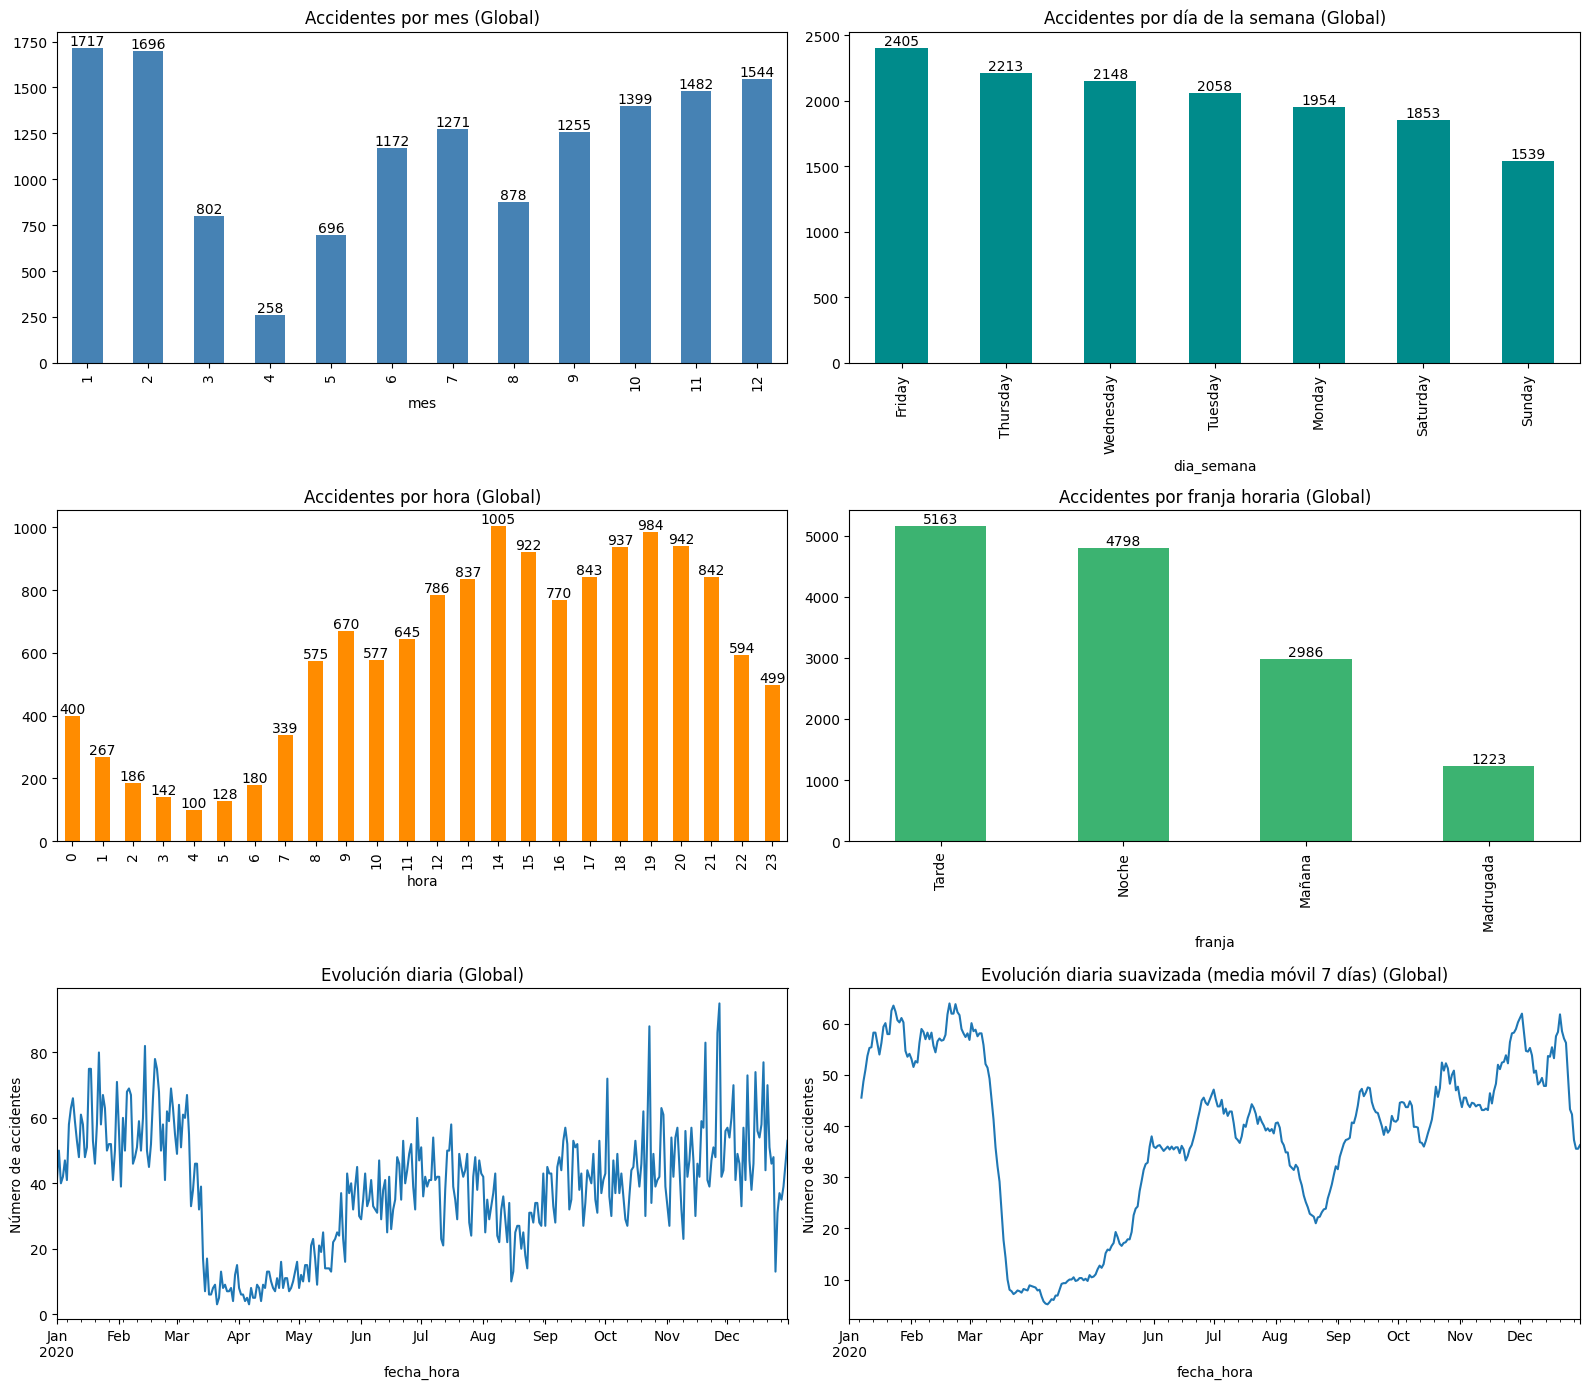

In [28]:
plot_temporal_univariate(df_20_unicos)

In [29]:
#FIGURA 1 (VERSIÓN 2)
#Función de variables temporales (versión 2):

def plot_temporal_univariate_2(df, col_datetime='fecha_hora', por_año=False):
    """
    Gráficos temporales univariantes:
    - Accidentes por mes (barras)
    - Accidentes por día de la semana
    - Accidentes por hora
    - Accidentes por franja horaria
    - Curva mensual ampliada (línea con puntos)
    - Curvas diarias por mes (12 gráficas adicionales)
    """

    if por_año:
        for año, df_año in df.groupby('año'):
            print(f"\n=== Gráficos para el año {año} ===")
            _graficos(df_año, col_datetime, titulo_extra=f"Año {año}")
    else:
        _graficos(df, col_datetime, titulo_extra="Global")


def _graficos(df, col_datetime, titulo_extra=""):

    plt.rcParams.update({'font.size': 12})
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['axes.titleweight'] = 'bold'
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['axes.linewidth'] = 1.5

    fig_1 = plt.figure(figsize=(16, 18))

    # 1. Accidentes por mes
    ax_mes = plt.subplot2grid((3, 2), (0, 0))
    freq_mes = (df['mes'].value_counts(normalize=True)*100).sort_index().round(2)
    freq_mes.plot(kind='bar', ax=ax_mes, color="steelblue",
                  title=f'Accidentes por mes ({titulo_extra})')
    ax_mes.set_xlabel("Mes")
    ax_mes.set_ylabel("Número de accidentes")
    ax_mes.bar_label(ax_mes.containers[0])
    total=len(df)
    ax_mes.text(
    0.5, 0.95, f'Total: {total} accidentes únicos', 
    transform=ax_mes.transAxes, 
    ha='right', va='top', fontsize=14)
    ax_mes.text(0.95,0.93,"(a)", transform=ax_mes.transAxes, fontsize=16)
    ax_mes.set_ylim(0,12)

    # 2. Accidentes por día de la semana
    dias_es = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
    map_dias = {
    "Monday": "Lunes",
    "Tuesday": "Martes",
    "Wednesday": "Miércoles",
    "Thursday": "Jueves",
    "Friday": "Viernes",
    "Saturday": "Sábado",
    "Sunday": "Domingo"
}
    df['dia_semana_es'] = df['dia_semana'].map(map_dias)

    ax_semana = plt.subplot2grid((3, 2), (0, 1))
    freq_semana = (df['dia_semana_es'].value_counts(normalize=True)*100).reindex(dias_es).round(2)
    freq_semana.plot(kind='bar', ax=ax_semana, color="gold",
                     title=f'Accidentes por día de la semana ({titulo_extra})')
    ax_semana.set_xlabel("Día de la semana")
    ax_semana.set_ylabel("Frecuencia (%)")
    ax_semana.bar_label(ax_semana.containers[0])
    ax_semana.text(0.95,0.93,"(b)", transform=ax_semana.transAxes, fontsize=16)
    ax_semana.set_ylim(0,20)

    # 3. Accidentes por hora
    ax_hora = plt.subplot2grid((3, 2), (1, 0))
    freq_hora = (df['hora'].value_counts(normalize=True)*100).sort_index().round(1)
    freq_hora.plot(kind='bar', ax=ax_hora, color="darkorange",
                   title=f'Accidentes por hora ({titulo_extra})')
    ax_hora.set_xlabel("Hora")
    ax_hora.set_ylabel("Frecuencia (%)")
    ax_hora.bar_label(ax_hora.containers[0])
    ax_hora.text(0.95,0.93,"(c)", transform=ax_hora.transAxes, fontsize=16)
    ax_hora.set_ylim(0,8)

    # 4. Accidentes por franja horaria
    orden_franjas = ["Madrugada", "Mañana", "Tarde", "Noche"]

    ax_franja = plt.subplot2grid((3, 2), (1, 1))
    freq_franja = (df['franja'].value_counts(normalize=True)*100).reindex(orden_franjas, fill_value=0).round(2)
    freq_franja.plot(kind='bar', ax=ax_franja, color="mediumseagreen",
                     title=f'Accidentes por franja horaria ({titulo_extra})')
    ax_hora.set_xlabel("Franja horaria")
    ax_franja.set_ylabel("Frecuencia (%)")
    ax_franja.bar_label(ax_franja.containers[0])
    ax_franja.text(0.95,0.93,"(d)", transform=ax_franja.transAxes, fontsize=16)
    ax_franja.set_ylim(0,40)

    # 5. Curva mensual ampliada
    ax_curva = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    frecuencia_mensual = df[col_datetime].dt.month.value_counts().sort_index()

    meses_es = [
        "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
        "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
    ]
    meses_plot = [meses_es[i-1] for i in frecuencia_mensual.index]

    ax_curva.plot(
        meses_plot, frecuencia_mensual.values,
        marker="o", linewidth=3, color="darkred"
    )
    ax_curva.set_title(f"Curva de frecuencia mensual ({titulo_extra})", fontsize=16)
    ax_curva.set_xlabel("Mes")
    ax_curva.set_ylabel("Número de accidentes")
    ax_curva.grid(True)
    for i, v in enumerate(frecuencia_mensual.values):
        ax_curva.text(i, v + 45, str(v), ha="center", fontsize=12)
    ax_curva.tick_params(axis="x", rotation=45)
    plt.ylim(750, 2250)
    ax_curva.text(0.97,0.93,"(e)", transform=ax_curva.transAxes, fontsize=16)



    plt.tight_layout()
    plt.show()

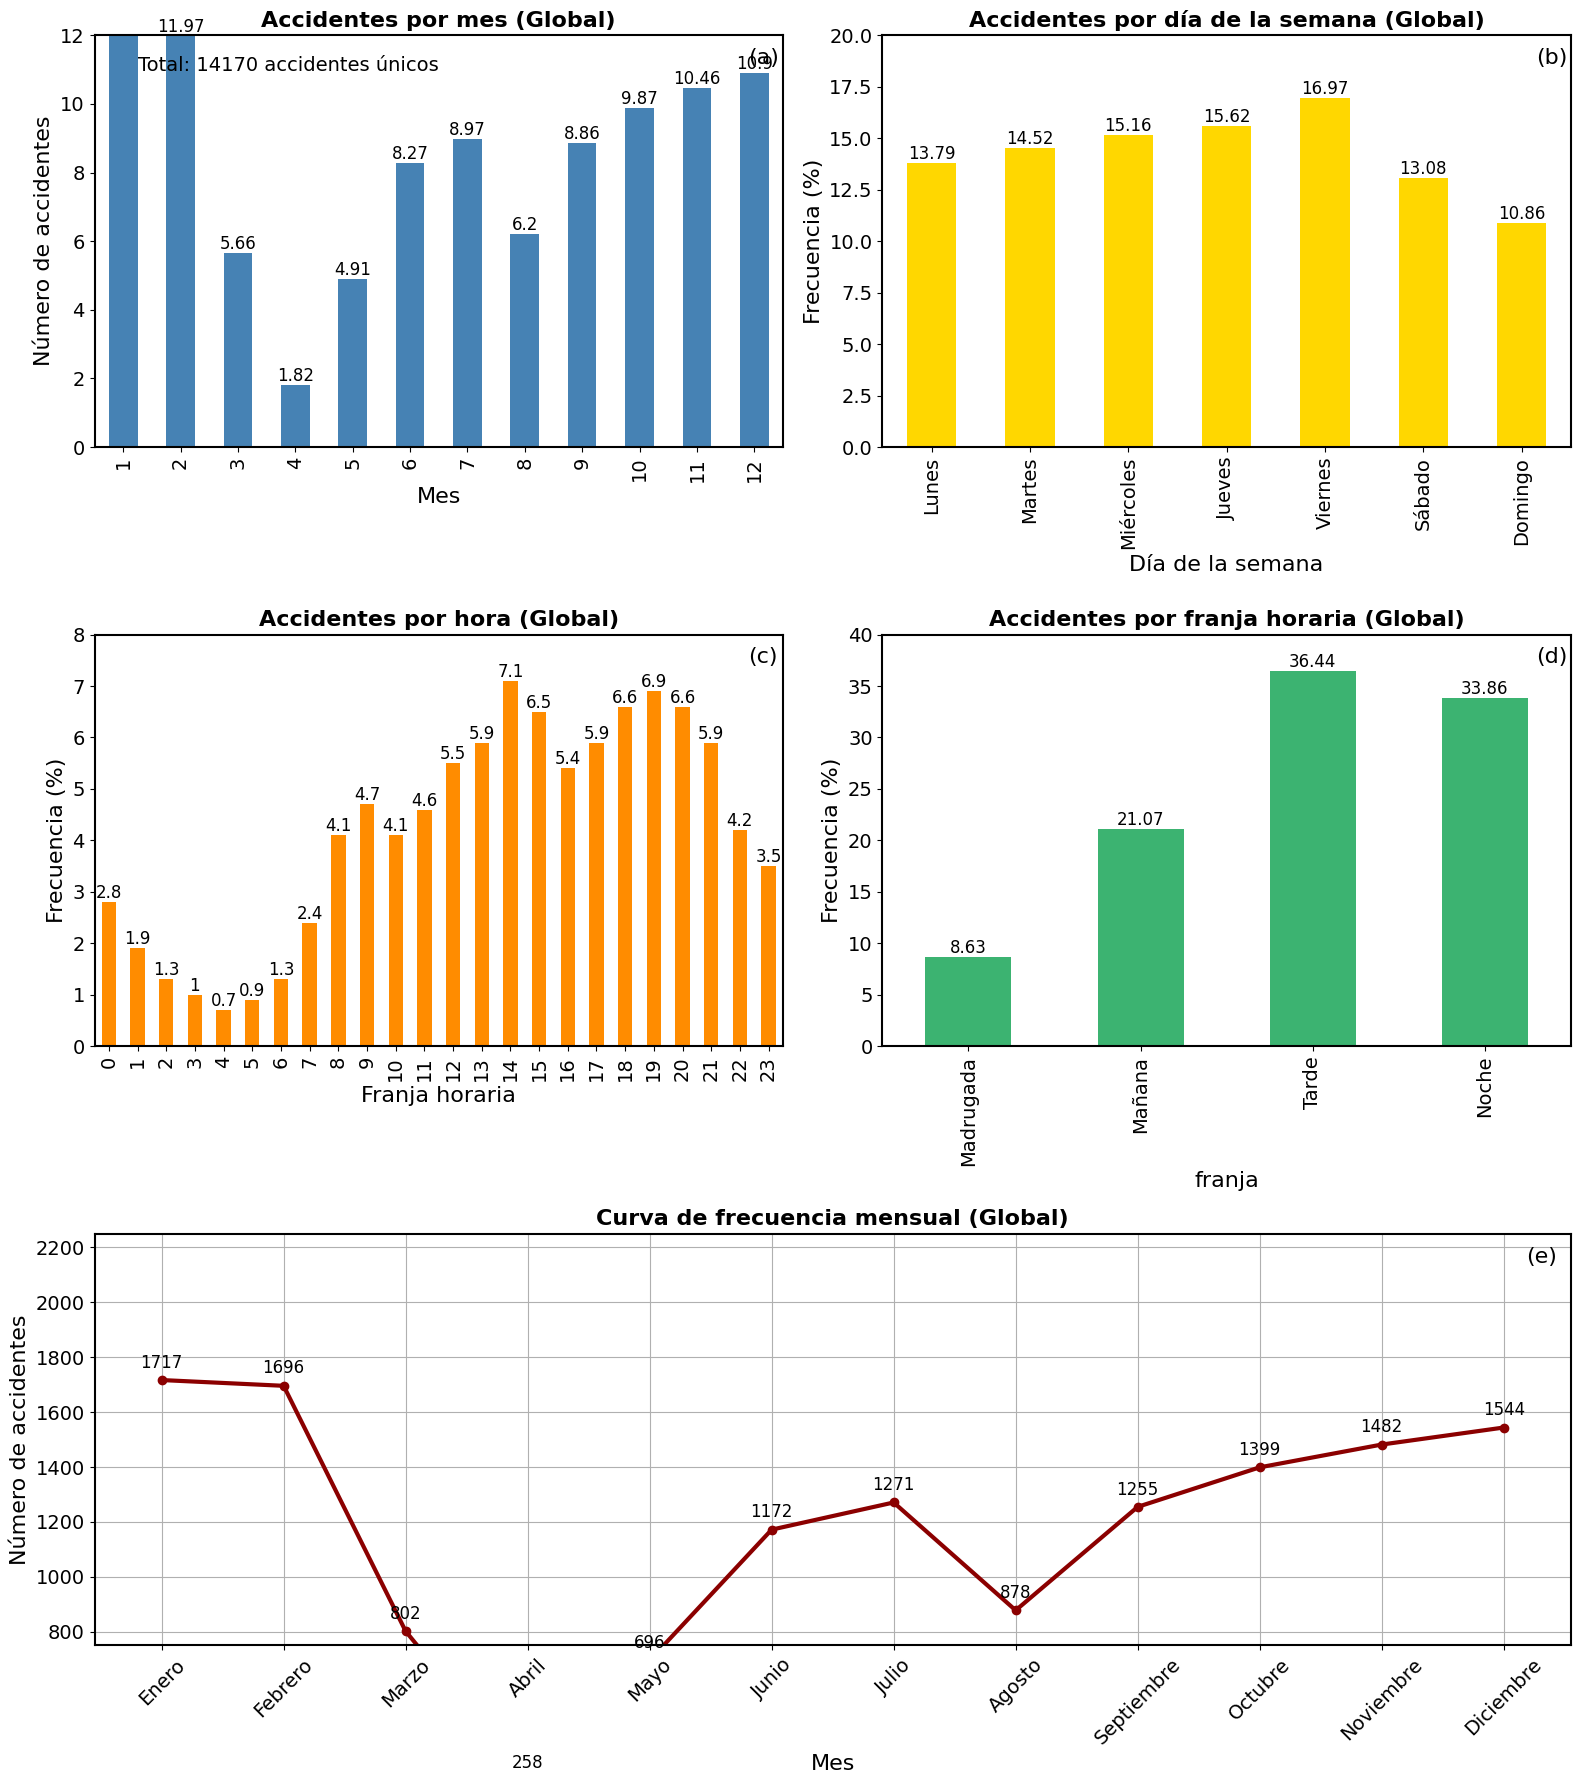

In [30]:
plot_temporal_univariate_2(df_20_unicos)

### Análisis geográfico

Generamos un función que normalizá datos geográficos (localizació y número) para identificar las ubicaciones con mayor siniestralidad (puntos negros):

In [31]:
#Funcion de normalización:


# 1. Funciones de normalización
def normalize_text(s):
    """Normaliza texto: minúsculas, espacios, sin tildes."""
    if pd.isna(s):
        return None
    s = s.lower().strip()
    s = " ".join(s.split())  # elimina dobles espacios
    s = ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
    return s

def normalize_numero(n):
    """Normaliza número de portal, detecta S/N."""
    if pd.isna(n):
        return None
    n = str(n).lower().strip()
    if n in ['s/n', 'sn', 's-n', '']:
        return None
    return n

# 2. Normalización de columnas clave
df = df_20

df['localizacion_norm'] = df['localizacion'].apply(normalize_text)
df['numero_norm'] = df['numero'].apply(normalize_numero)
df['num_expediente'] = df['num_expediente'].astype(str).str.strip()

# eliminar duplicados exactos de num expediente
df = df.drop_duplicates(subset=['num_expediente'])


# 3. Construcción de clave de localización final
df['clave_localizacion'] = (
    df['localizacion_norm'].fillna('') + 'n' +
    df['numero_norm'].fillna('')
).str.strip()

# 4. Detección de puntos negros con distrito
puntos_negros = (
    df.groupby(['localizacion_norm', 'distrito'])['num_expediente']
      .nunique()
      .reset_index(name='n_expedientes')
      .sort_values('n_expedientes', ascending=False)
)

# filtrar solo localizaciones con más de un accidente distinto
puntos_negros = puntos_negros[puntos_negros['n_expedientes'] > 1]

# 5. Resultado final
puntos_negros

C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\871198139.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['localizacion_norm', 'distrito'])['num_expediente']


localizacion_norm            distrito  \
7707                     autov. m-30, +01100i          ARGANZUELA   
111311  call. fuente carrantona / autov. m-23           MORATALAZ   
6691                     autov. m-30, +00800i              RETIRO   
9271                     autov. m-30, +02300i     MONCLOA-ARAVACA   
2459                     autov. a-42, +00500s         CARABANCHEL   
...                                       ...                 ...   
52405      avda. reyes catolicos / autov. a-6     MONCLOA-ARAVACA   
230517                       ronda. atocha, 5          ARGANZUELA   
230779                   ronda. provincias, 7     MONCLOA-ARAVACA   
231117          ronda. sur / call. los barros  PUENTE DE VALLECAS   
231745               trva. antonio nebrija, 1     MONCLOA-ARAVACA   

        n_expedientes  
7707               32  
111311             14  
6691               14  
9271               13  
2459               13  
...               ...  
52405               2  
230517              2  
230779              2  
231117              2  
231745              2  

[1736 rows x 3 columns]

Dibujamos la frecuencia de accidentes por distrito y los 3 puntos negros (Figura 2):

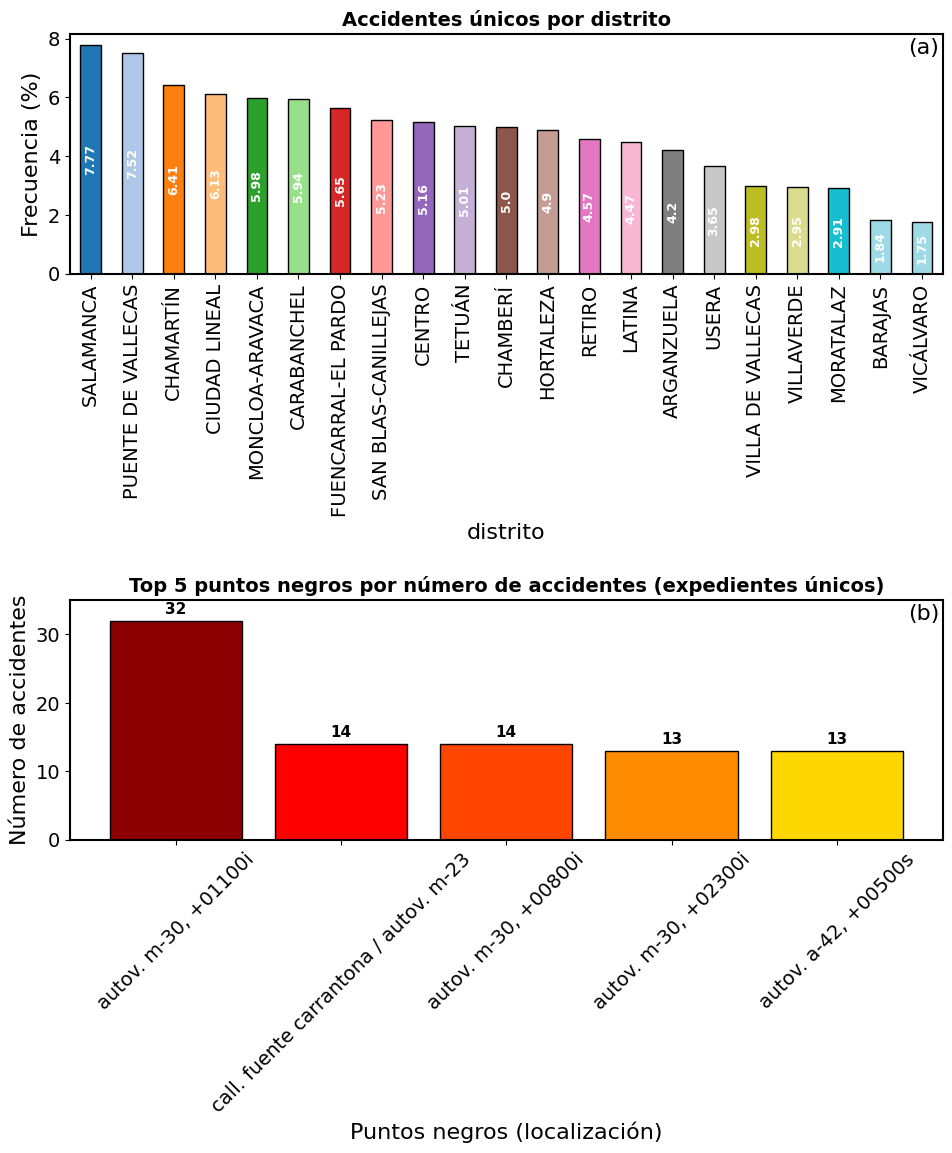

In [32]:
#FIGURA 2

plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1.5


fig_2 = plt.figure(figsize=(10, 12))

accidentes_distrito=(df_20_unicos["distrito"].value_counts(normalize = True)*100).round(2)
colores_distritos = plt.cm.tab20(range(len(accidentes_distrito)))

ax1=plt.subplot(2, 1, 1)
ax1=accidentes_distrito.plot(kind="bar", color=colores_distritos, ax =ax1, edgecolor='black')

ax1.set_title("Accidentes únicos por distrito", fontweight='bold')
ax1.set_ylabel("Frecuencia (%)")

for p, value in zip(ax1.patches, accidentes_distrito):
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2   # centrado verticalmente dentro de la barra

    ax1.annotate(
        f"{value}",
        (x, y),
        ha="center", va="center",
        rotation=90,          #  texto tumbado
        fontsize=9, color="white", fontweight="bold"
    )
ax1.text(0.96, 0.92, '(a)', transform=ax1.transAxes, fontsize=16)

# Seleccionar los 5 puntos negros con más accidentes
top5 = puntos_negros.nlargest(5, 'n_expedientes').copy()

# Resetear índice para evitar problemas de posición
top5 = top5.reset_index(drop=True)

ax2 = plt.subplot(2,1,2)

paleta_top5 = ["#8B0000", "#FF0000", "#FF4500", "#FF8C00", "#FFD700"]
bars2 = ax2.bar(top5['localizacion_norm'], top5['n_expedientes'], 
                color=paleta_top5, edgecolor='black', linewidth=1)

ax2.set_title('Top 5 puntos negros por número de accidentes (expedientes únicos)')
ax2.set_xlabel("Puntos negros (localización)")
ax2.set_ylabel("Número de accidentes")
ax2.tick_params(axis="x", rotation=45)
ax2.text(0.96, 0.92, '(b)', transform=ax2.transAxes, fontsize=16)
ax2.bar_label(bars2, padding=3, fontweight='bold', fontsize=11)
ax2.set_ylim(0,35)
plt.tight_layout(pad=2.0)
plt.show()


### Análisis demográfico

Gráficamos las frecuencias de accidentes en función de datos demográficos: rango de edad, sexo y tipo de persona

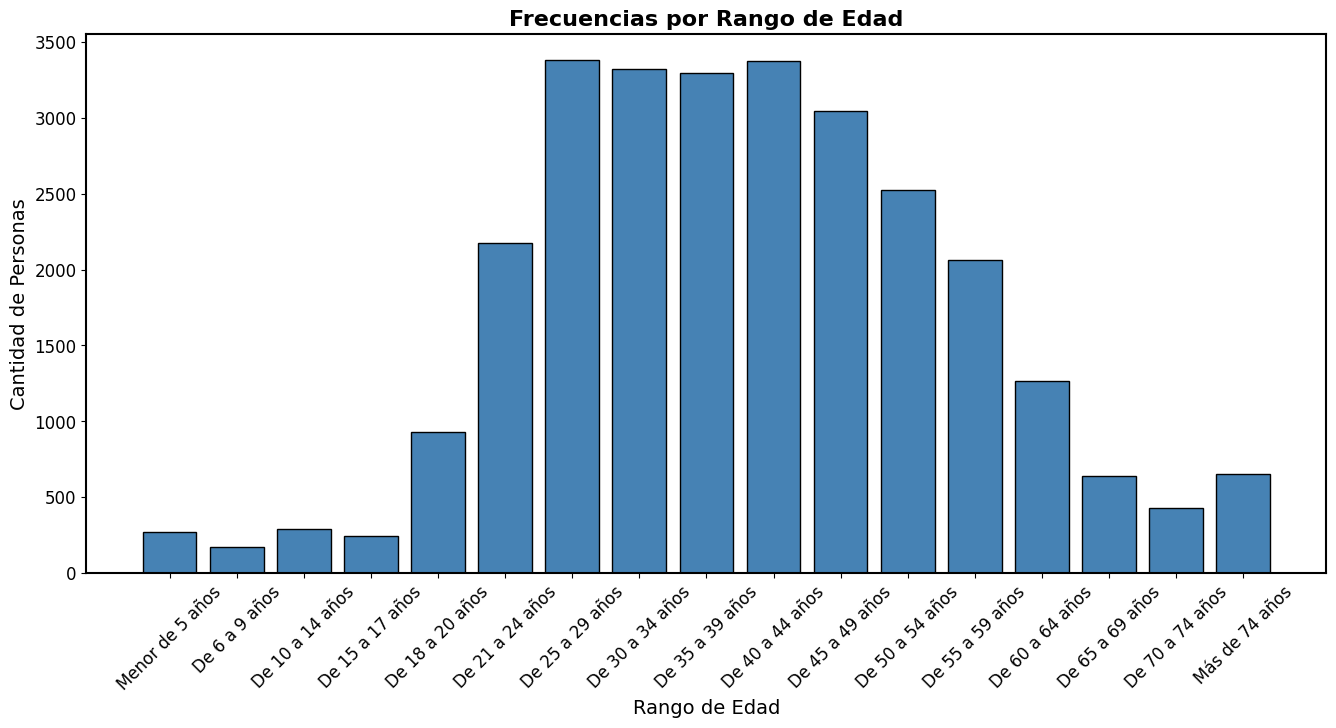

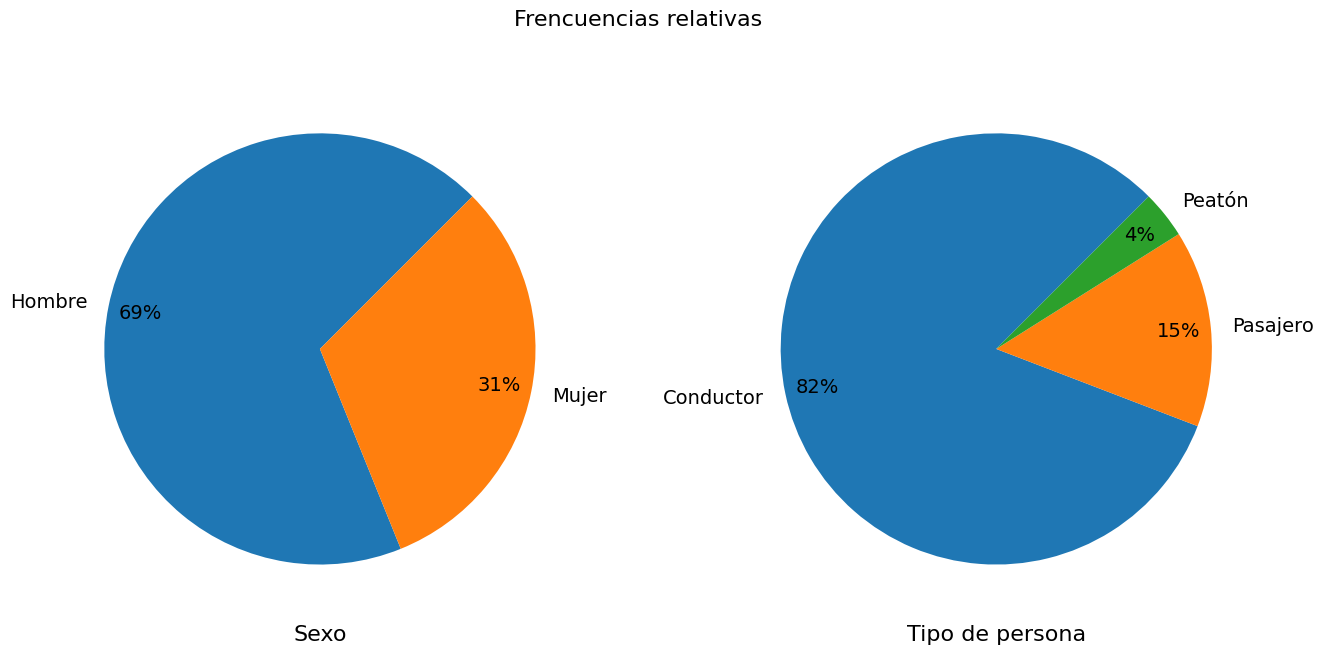

In [33]:
#FIGURA 3 (VERSIÓN 1)
#Sintaxis de python
#Orden correcto de rangos de edad 

edades=df_20.rango_edad.value_counts().sort_index()
fig_3a=plt.figure(figsize=(16,7))
plt.bar(edades.index, edades, color="steelblue", edgecolor="black")
plt.title("Frecuencias por Rango de Edad", fontsize=16) 
plt.xlabel("Rango de Edad", fontsize=14)
plt.ylabel("Cantidad de Personas", fontsize=14)
plt.xticks(fontsize=12, rotation=45) # Rotación por si los nombres son largos
plt.yticks(fontsize=12);

fig_3b, axs=plt.subplots(1, 2, figsize=(16, 7))
pie_kwargs = {
    'autopct': '%1.0f%%',
    'startangle': 45,
    'textprops': {'fontsize': 14}, # Aumenta tamaño de letra (porcentajes y etiquetas)
    'pctdistance': 0.85,           # Posición de los porcentajes (0=centro, 1=borde)
    'labeldistance': 1.1           # Posición de los nombres (1.1 está justo afuera)
}
fig_3b.suptitle("Frencuencias relativas", fontsize=16)
axs[0].set_xlabel("Sexo")
sexo_counts= df_20.sexo.value_counts(normalize=True).drop("Desconocido", errors='ignore')
axs[0].pie(sexo_counts, 
           labels=sexo_counts.index,**pie_kwargs)
axs[1].set_xlabel("Tipo de persona")
axs[1].pie(df_20.tipo_persona.value_counts(normalize=True)*100, 
           labels=df_20.tipo_persona.value_counts().index,**pie_kwargs);


C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\740675888.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sexo_counts = df_20.groupby('tipo_persona')['sexo'].value_counts(normalize=True)\


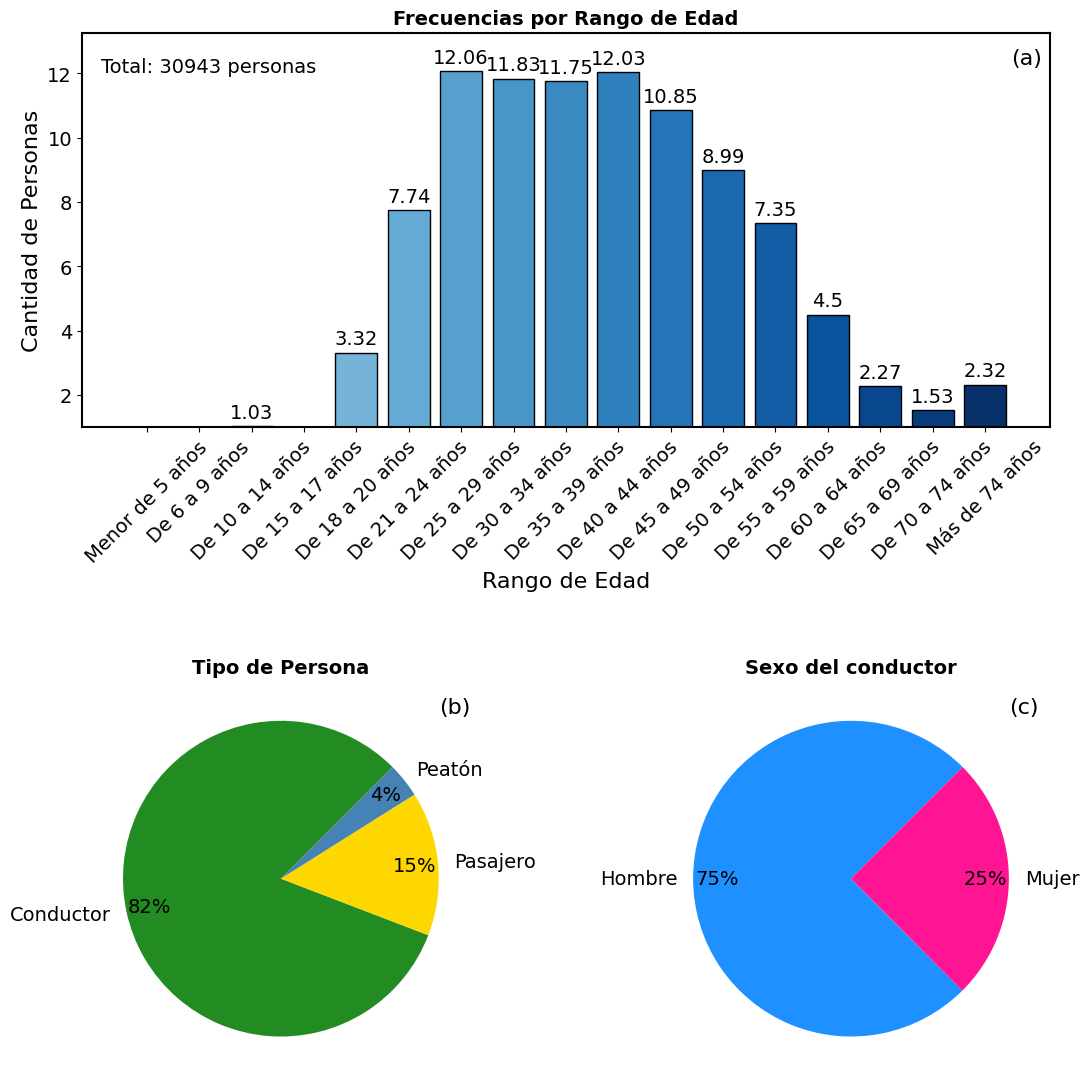

In [34]:
#ANÁLISIS DEMOGRÁFICO
#FIGURA 3 (VERSIÓN 2)


edad_counts = (df_20.rango_edad.value_counts(normalize=True)*100).drop("Desconocido", errors="ignore").sort_index().round(2)
sexo_counts = df_20.groupby('tipo_persona')['sexo'].value_counts(normalize=True)\
    .loc['Conductor'].drop("Desconocido", errors='ignore') #Contabilizamos únicamente el sexo de los conductores
tipo_counts = df_20.tipo_persona.value_counts(normalize=True)

plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1.5

fig_3 = plt.figure(figsize=(12, 12))


ax1 = plt.subplot(2, 1, 1) #ocupa todo el ancho
colores=plt.cm.Blues(np.linspace(0.3,1,len(edades)))
bars=ax1.bar(edad_counts.index, edad_counts, color=colores, edgecolor="black")
ax1.set_title("Frecuencias por Rango de Edad") 
ax1.set_xlabel("Rango de Edad")
ax1.set_ylabel("Cantidad de Personas")
ax1.bar_label(bars, padding=3, fontsize=14)
total_involucrados=len(df_20)
ax1.text(0.02, 0.90, f"Total: {total_involucrados} personas",
         transform=ax1.transAxes, fontsize=14)
plt.xticks(rotation=45)
#lt.yticks(fontsize=14)
max_val = edad_counts.max()
ax1.set_ylim(bottom=1, top=max_val * 1.1)
ax1.text(0.96, 0.92, '(a)', transform=ax1.transAxes, fontsize=16)

pie_kwargs = {
    'autopct': '%1.0f%%',
    'startangle': 45,
    'textprops': {'fontsize': 14},
    'pctdistance': 0.85,
    'labeldistance': 1.1
}

ax2 = plt.subplot(2, 2, 3) # Fila 1, Columna 2
ax2.pie(tipo_counts, labels=tipo_counts.index, colors=["forestgreen", "gold", "steelblue"], **pie_kwargs)
ax2.set_title("Tipo de Persona")
ax2.text(0.9, 0.92, '(b)', transform=ax2.transAxes, fontsize=16)

ax3 = plt.subplot(2, 2, 4) # Fila 1, Columna 1
ax3.pie(sexo_counts, labels=sexo_counts.index, colors=["dodgerblue", "deeppink"], **pie_kwargs)
ax3.set_title("Sexo del conductor")
ax3.text(0.9, 0.92, '(c)', transform=ax3.transAxes, fontsize=16)


plt.tight_layout(pad=4.0) #para que no se solapen
# plt.show()

### Factores asociados al accidente

Gráficamos las frecuencias de accidente por tipos de factores asociados al accidente:

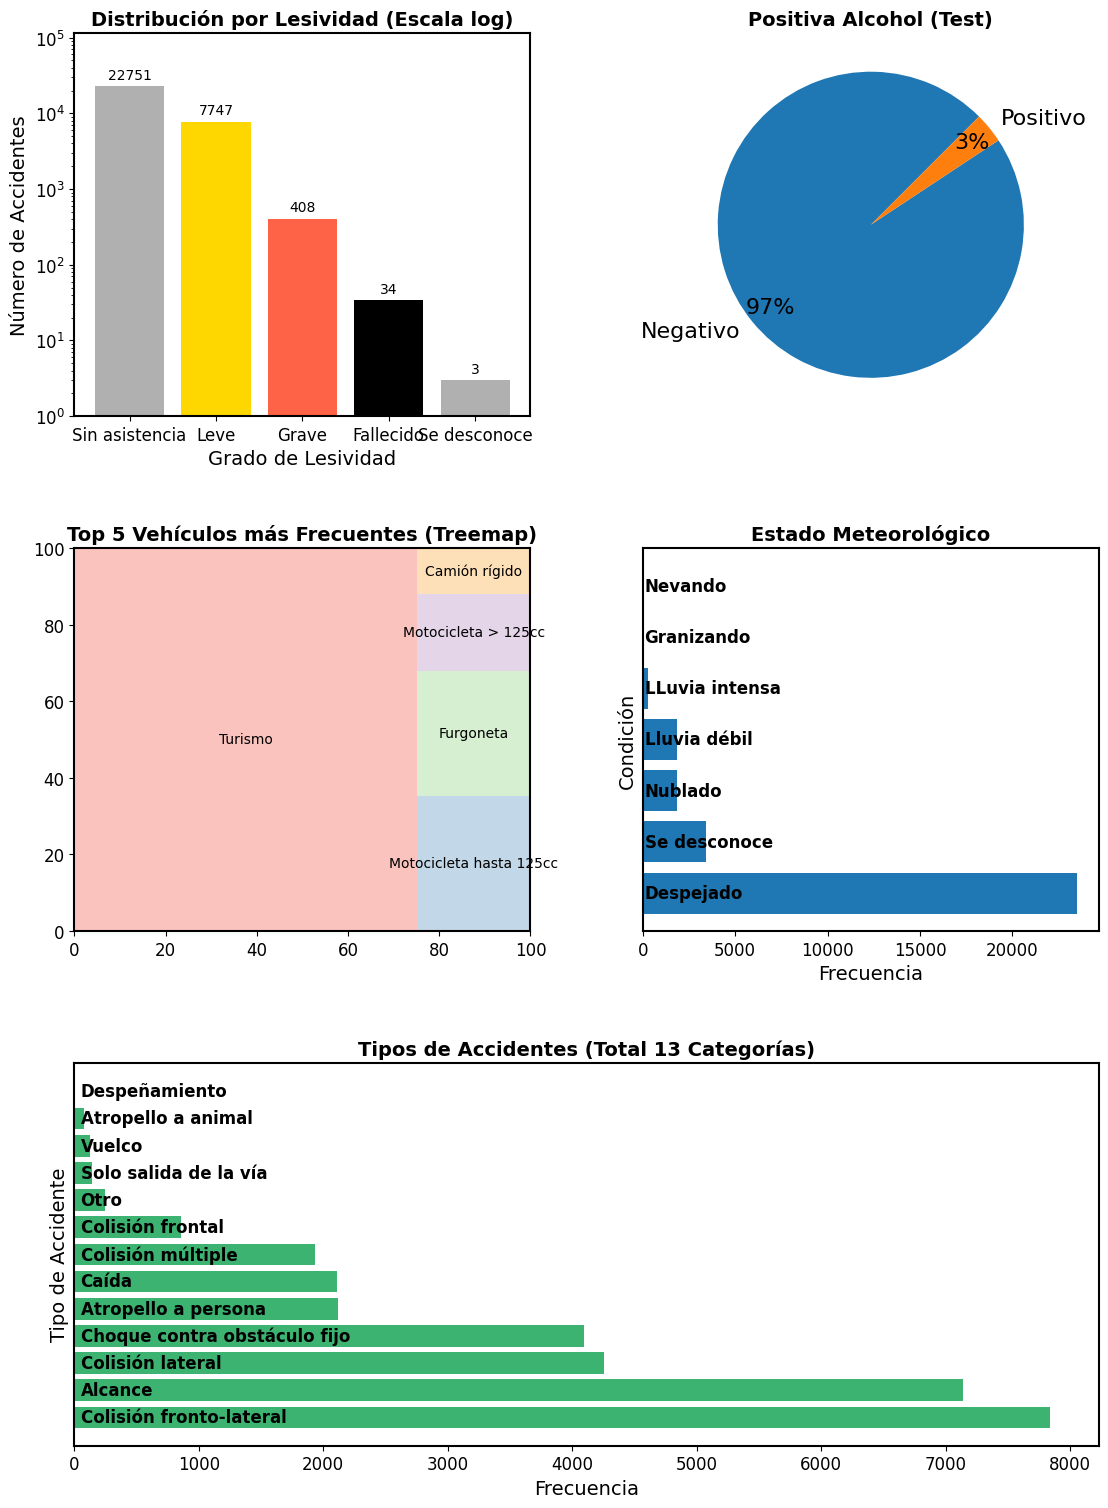

In [35]:
# FIGURA 4 (VERSIÓN 1)
# Variables: lesividad, tipo_accidente, tipo_vehiculo, estado_meteorológico, positiva_alcohol
# Bar Chart: Para tipo_accidente y tipo_vehiculo. 
# Treemap: Si tienes muchas categorías en tipo_vehiculo,un Treemap ayuda a ver visualmente cuáles predominan. 
# Waffle Chart: Muy visual para positiva_alcohol (ej. cuántos de cada 100 dieron positivo).


fig_4 = plt.figure(figsize=(12, 16))

plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

lesividad_counts=df_20.lesividad.value_counts()
lesividad_counts=lesividad_counts.rename({"Sin asistencia sanitaria": "Sin asistencia"})
alcohol_counts=df_20.positiva_alcohol.value_counts().drop("No consta", errors="ignore")
vehiculo_counts=df_20.tipo_vehiculo.value_counts().nlargest(5)
meteo_counts=df_20.estado_meteorológico.value_counts()
tipo_counts=df_20.tipo_accidente.value_counts()

ax1=plt.subplot(3,2,1)
ax1.set_title("Distribución por Lesividad (Escala log)", fontweight='bold')
colores_lesividad = ['#B0B0B0', '#FFD700', '#FF6347', '#000000']
bars=ax1.bar(lesividad_counts.index, lesividad_counts, color=colores_lesividad )
ax1.set_yscale("log")
ax1.set_xlabel('Grado de Lesividad', fontsize=14)
ax1.set_ylabel('Número de Accidentes', fontsize=14)

ax1.bar_label(bars, padding=3, fontsize=10)
max_val = lesividad_counts.max()
ax1.set_ylim(bottom=1, top=max_val * 5)

pie_kwargs = {
    'autopct': '%1.0f%%',
    'startangle': 45,
    'textprops': {'fontsize': 16},
    'pctdistance': 0.85,
    'labeldistance': 1.1
}

ax2=plt.subplot(3,2,2)
ax2.set_title('Positiva Alcohol (Test)', fontweight='bold')
ax2.pie(alcohol_counts, labels=alcohol_counts.index, **pie_kwargs)

ax3=plt.subplot(3,2,3)
ax3.set_title('Top 5 Vehículos más Frecuentes (Treemap)', fontweight='bold')
squarify.plot(sizes=vehiculo_counts.values, label=vehiculo_counts.index, 
              alpha=0.8, ax=ax3, color=plt.cm.Pastel1.colors)

ax4=plt.subplot(3,2,4)
ax4.set_title('Estado Meteorológico', fontweight='bold')
bars4=ax4.barh(meteo_counts.index, meteo_counts)
ax4.set_xlabel('Frecuencia', fontsize=14)
ax4.set_ylabel('Condición', fontsize=14)
ax4.set_yticks([])

for i, bar in enumerate(bars4):
    width = bar.get_width()
    ax4.text(100, i, 
             meteo_counts.index[i], 
             fontsize=12, 
             va='center',     # Centrado verticalmente respecto al grosor de la barra
             ha='left',       # Alineado a la izquierda
             fontweight='bold')   

ax5 = plt.subplot(3,1,3) 
bars5 = ax5.barh(tipo_counts.index, tipo_counts, color='mediumseagreen')
ax5.set_title('Tipos de Accidentes (Total 13 Categorías)', fontweight='bold')
ax5.set_xlabel('Frecuencia', fontsize=14)
ax5.set_ylabel('Tipo de Accidente', fontsize=14)
ax5.set_yticks([])
for i, bar in enumerate(bars5):
    width = bar.get_width()
    ax5.text(50, i, 
             tipo_counts.index[i], 
             fontsize=12, 
             va='center',     # Centrado verticalmente respecto al grosor de la barra
             ha='left',       # Alineado a la izquierda
             fontweight='bold')   
plt.tight_layout(pad=4.0) # Para que no se solapen los títulos


C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\94303113.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vehiculo_counts=df_20.groupby("tipo_persona")["tipo_vehiculo"].value_counts() \
C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\94303113.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  alcohol_counts=df_20.groupby("tipo_persona")["positiva_alcohol"].value_counts() \
C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\94303113.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib

<Figure size 1200x1600 with 0 Axes>

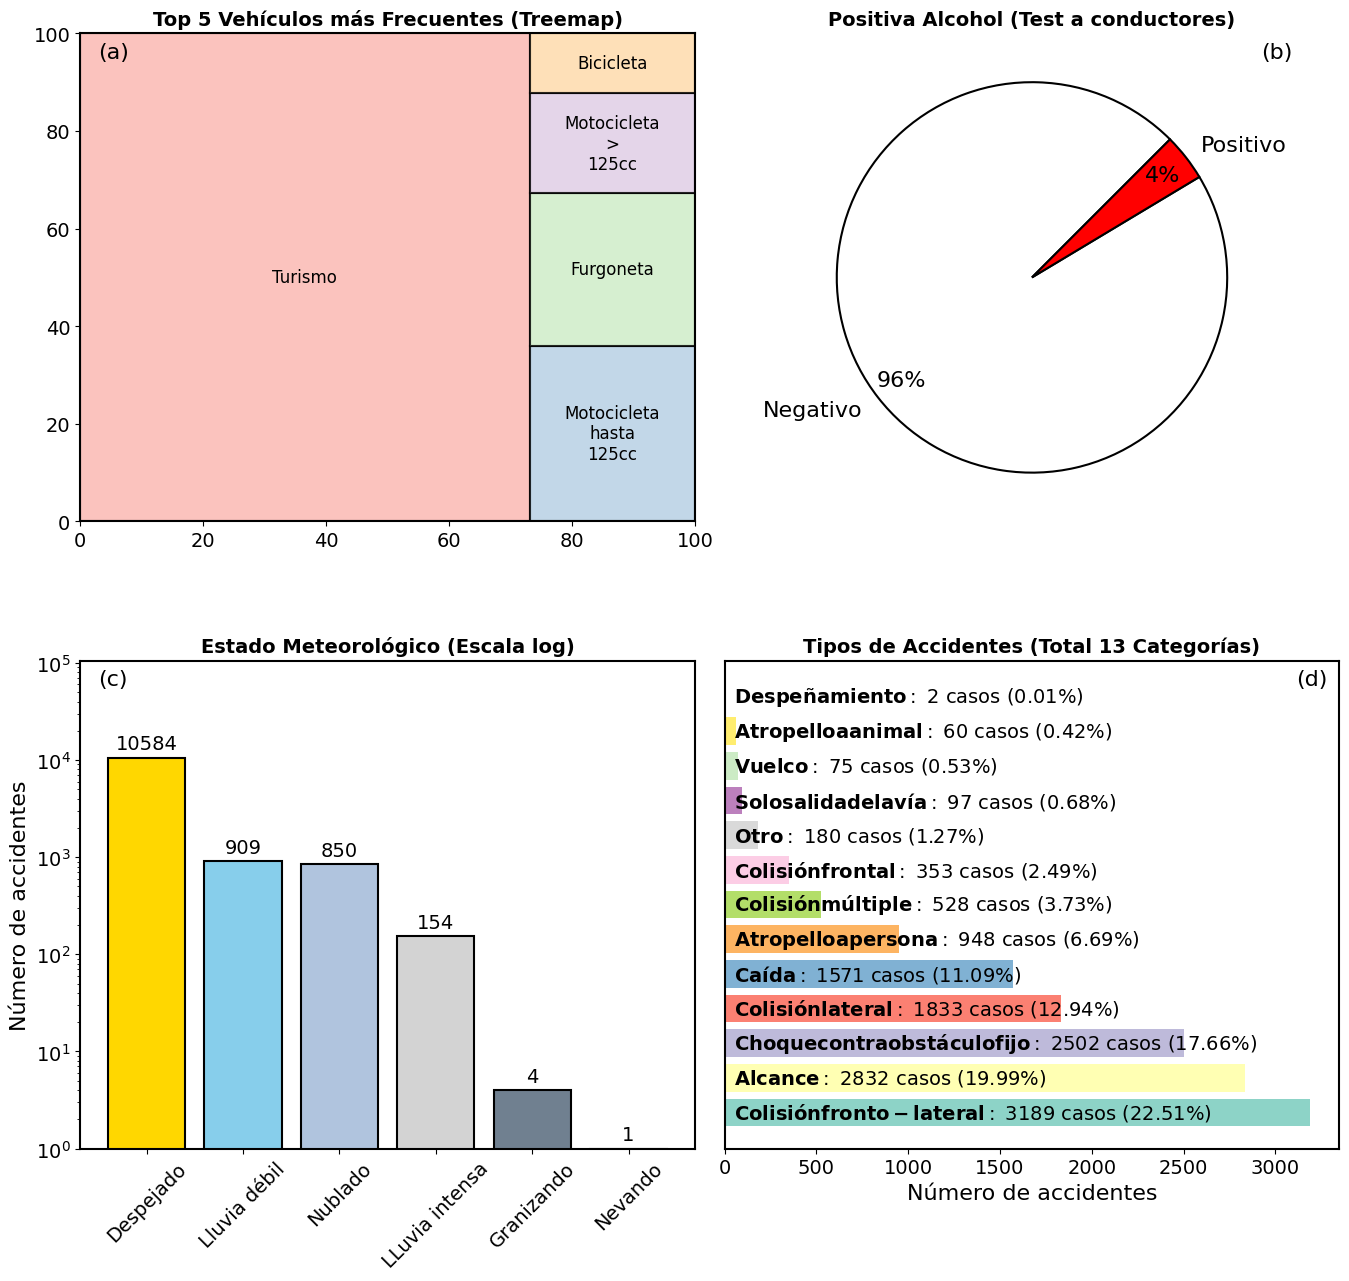

In [36]:
# FIGURA 4 (VERSIÓN 2)
# Variables: lesividad, tipo_accidente, tipo_vehiculo, estado_meteorológico, positiva_alcohol
# Bar Chart: Para tipo_accidente y tipo_vehiculo. 
# Treemap: Si tienes muchas categorías en tipo_vehiculo,un Treemap ayuda a ver visualmente cuáles predominan. 
# Waffle Chart: Muy visual para positiva_alcohol (ej. cuántos de cada 100 dieron positivo).

import matplotlib.cm as cm

fig_4 = plt.figure(figsize=(12, 16))

plt.rcParams.update({'font.size': 12})
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1.5


vehiculo_counts=df_20.groupby("tipo_persona")["tipo_vehiculo"].value_counts() \
    .loc["Conductor"].nlargest(5)
alcohol_counts=df_20.groupby("tipo_persona")["positiva_alcohol"].value_counts() \
    .loc["Conductor"].drop("No consta", errors="ignore")
meteo_counts=df_20_unicos.estado_meteorológico.value_counts().drop(["Se desconoce", "No consta"], errors="ignore")
tipo_counts=df_20_unicos.tipo_accidente.value_counts()
tipo_counts_normalizado=(df_20_unicos.tipo_accidente.value_counts(normalize=True)*100).round(2)




pie_kwargs = {
    'autopct': '%1.0f%%',
    'startangle': 45,
    'textprops': {'fontsize': 16},
    'pctdistance': 0.85,
    'labeldistance': 1.1
}

wedge_props = {
    'edgecolor': 'black', # Color de la línea de separación
    'linewidth': 1.5,# Grosor de la línea
    'antialiased': True
}

fig_4 = plt.figure(figsize=(14, 18)) 


ax1 = plt.subplot(3, 2, 1) # (3 filas, 1 columna, posición 2)
ax1.set_title('Top 5 Vehículos más Frecuentes (Treemap)', fontweight='bold')
labels_con_salto = [label.replace(" ", "\n") for label in vehiculo_counts.index]
squarify.plot(sizes=vehiculo_counts.values, label=labels_con_salto, 
              alpha=0.8, ax=ax1, color=plt.cm.Pastel1.colors, edgecolor="black", linewidth=1.5, pad=False)
ax1.text(0.03, 0.95, '(a)', transform=ax1.transAxes, fontsize=16)


#ax1.axis('off') # El treemap no necesita ejes

ax2 = plt.subplot(3, 2, 2)
ax2.set_title('Positiva Alcohol (Test a conductores)', fontweight='bold')
colores_alcohol = ["white", "red"]
ax2.pie(alcohol_counts, labels=alcohol_counts.index, colors=colores_alcohol, wedgeprops=wedge_props, **pie_kwargs)
ax2.text(0.97, 0.95, '(b)', transform=ax2.transAxes, fontsize=16)

ax3 = plt.subplot(3, 2, 3)
ax3.set_title('Estado Meteorológico (Escala log)', fontweight='bold')
mapa_colores_meteo = {
    'Despejado': '#FFD700',
    'Nublado': '#B0C4DE',
    'Lluvia débil': '#87CEEB',
    'Lluvia intensa': '#4682B4',
    'Nevando': '#F0F8FF',
    'Granizando': '#708090'
}
colores_para_grafico = [mapa_colores_meteo.get(cat, '#D3D3D3') for cat in meteo_counts.index]
bars3 = ax3.bar(meteo_counts.index, meteo_counts, color=colores_para_grafico, linewidth=1.5, edgecolor='black') 
ax3.set_yscale("log")
ax3.tick_params(axis='x', rotation=45)
ax3.set_ylabel('Número de accidentes')
ax3.bar_label(bars3, padding=3, fontsize=14)
max_val = meteo_counts.max()
ax3.set_ylim(bottom=1, top=max_val * 10)
ax3.text(0.03, 0.95, '(c)', transform=ax3.transAxes, fontsize=16)

ax4 = plt.subplot(3, 2, 4) 
colores_accidentes = cm.get_cmap('Set3')(range(13))
bars4 = ax4.barh(tipo_counts.index, tipo_counts, color=colores_accidentes)
ax4.set_title('Tipos de Accidentes (Total 13 Categorías)', fontweight='bold')
ax4.set_xlabel("Número de accidentes")
ax4.set_yticks([])
ax4.text(0.93, 0.95, '(d)', transform=ax4.transAxes, fontsize=16)

for i, bar in enumerate(bars4):
    #texto_etiqueta = f"{tipo_counts.index[i]}: {tipo_counts.values[i]} casos"
    texto = f"$\\mathbf{{{tipo_counts.index[i]}}}:$ {tipo_counts.values[i]} casos ({tipo_counts_normalizado[i]}%)"
    ax4.text(50, i, texto, fontsize=14, va='center', ha='left')

plt.tight_layout(pad=1.0)
plt.show();

### Grado de Lesividad

Por último, dibujamos las frecuencias de accidente en función del grado de lesividad (variable más importante)

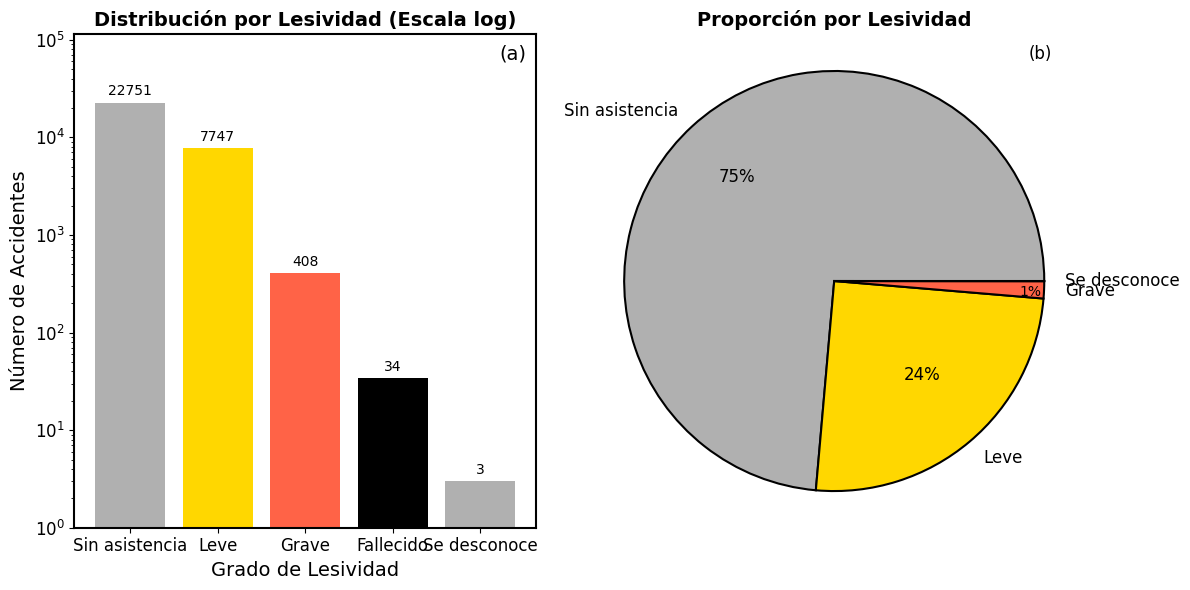

In [37]:
#FIGURA 5

fig_5 = plt.figure(figsize=(12, 6))

plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

lesividad_counts=df_20.lesividad.value_counts().rename({"Sin asistencia sanitaria": "Sin asistencia"})
Lesividad_sin_fallecido=lesividad_counts.drop(["Fallecido"], errors="ignore")



ax1=plt.subplot(1,2,1)
ax1.set_title("Distribución por Lesividad (Escala log)", fontweight='bold')
colores_lesividad = ['#B0B0B0', '#FFD700', '#FF6347', '#000000']
bars=ax1.bar(lesividad_counts.index, lesividad_counts, color=colores_lesividad )
ax1.set_yscale("log")
ax1.set_xlabel('Grado de Lesividad', fontsize=14)
ax1.set_ylabel('Número de Accidentes', fontsize=14)

ax1.bar_label(bars, padding=3, fontsize=10)
max_val = lesividad_counts.max()
ax1.set_ylim(bottom=1, top=max_val * 5)
ax1.text(0.92, 0.95, '(a)', transform=ax1.transAxes, fontsize=14)

# pie_kwargs = {
#     'autopct': '%1.0f%%',
#     'startangle': 45,
#     'textprops': {'fontsize': 14},
#     'pctdistance': 0.85,
#     'labeldistance': 1.1,
#     'rotatelabels': True
# }

ax2=plt.subplot(1,2,2)
ax2.set_title("Proporción por Lesividad", fontweight='bold')

wedge_props = {'edgecolor': 'black', 'linewidth': 1.5}
ax2.pie(
    Lesividad_sin_fallecido, 
    labels=Lesividad_sin_fallecido.index, 
    colors=colores_lesividad,
    wedgeprops=wedge_props,
)

ax2.axis('equal')

# Identificador (b)
ax2.text(0.92, 0.95, '(b)', transform=ax2.transAxes, fontsize=12)
ax2.text(0.25, 0.7, "75%", transform=ax2.transAxes, fontsize=12)
ax2.text(0.65, 0.3, "24%", transform=ax2.transAxes, fontsize=12)
ax2.text(0.9, 0.47, "1%", transform=ax2.transAxes, fontsize=10)

plt.tight_layout()
plt.show()

##  Análisis bivariante

In [38]:
df_20

num_expediente      fecha      hora  \
0        2019s040008 2020-09-07  23:00:00   
1        2019s040008 2020-09-07  23:00:00   
2        2020s000001 2020-01-01  01:15:00   
3        2020s000001 2020-01-01  01:15:00   
4        2020s000002 2020-01-01  01:20:00   
...              ...        ...       ...   
32426    2020s019608 2020-12-28  06:55:00   
32427    2020s019610 2020-12-22  23:10:00   
32428    2020s019624 2020-12-14  11:30:00   
32429    2020s019624 2020-12-14  11:30:00   
32432    2020s019648 2020-11-23  12:54:00   

                                       localizacion numero  \
0                         call. san maximiliano, 38     38   
1                         call. san maximiliano, 38     38   
2      avda. canillejas a vicalvaro / call. silfide      1   
3      avda. canillejas a vicalvaro / call. silfide      1   
4                                 call. silvano, 31     31   
...                                             ...    ...   
32426                             call. honrubia, 4      4   
32427  call. castrillo de aza / avda. santa eugenia      1   
32428                    call. jose arcones gil, 17     17   
32429                    call. jose arcones gil, 17     17   
32432                   call. francisco silvela, 30     30   

                  distrito                tipo_accidente estado_meteorológico  \
0            CIUDAD LINEAL  Choque contra obstáculo fijo            Despejado   
1            CIUDAD LINEAL  Choque contra obstáculo fijo            Despejado   
2      SAN BLAS-CANILLEJAS       Colisión fronto-lateral         Se desconoce   
3      SAN BLAS-CANILLEJAS       Colisión fronto-lateral         Se desconoce   
4                HORTALEZA  Choque contra obstáculo fijo            Despejado   
...                    ...                           ...                  ...   
32426    VILLA DE VALLECAS           Atropello a persona         Lluvia débil   
32427    VILLA DE VALLECAS  Choque contra obstáculo fijo              Nublado   
32428        CIUDAD LINEAL              Colisión lateral            Despejado   
32429        CIUDAD LINEAL              Colisión lateral            Despejado   
32432            SALAMANCA                         Caída              Nublado   

                 tipo_vehiculo tipo_persona       rango_edad         sexo  \
0                      Turismo    Conductor  De 21 a 24 años       Hombre   
1                VMU eléctrico    Conductor  De 25 a 29 años        Mujer   
2                      Turismo    Conductor  De 18 a 20 años       Hombre   
3                      Turismo    Conductor  De 30 a 34 años       Hombre   
4                      Turismo    Conductor  De 21 a 24 años       Hombre   
...                        ...          ...              ...          ...   
32426                  Turismo       Peatón  De 45 a 49 años        Mujer   
32427                  Turismo    Conductor              NaN  Desconocido   
32428            Camión rígido    Conductor  De 35 a 39 años       Hombre   
32429                  Turismo    Conductor              NaN  Desconocido   
32432  Motocicleta hasta 125cc    Conductor  De 30 a 34 años       Hombre   

                      lesividad coordenada_x_utm coordenada_y_utm  \
0      Sin asistencia sanitaria           444578          4475148   
1      Sin asistencia sanitaria           444578          4475148   
2      Sin asistencia sanitaria           447894          4476691   
3      Sin asistencia sanitaria           447894          4476691   
4      Sin asistencia sanitaria           445094          4478370   
...                         ...              ...              ...   
32426                      Leve           446415          4469141   
32427  Sin asistencia sanitaria           448477          4470746   
32428  Sin asistencia sanitaria           445840          4476212   
32429  Sin asistencia sanitaria           445840          4476212   
32432  Sin asistencia sanitaria           442999          44759

Antes de nada generamos una copia del dataset limpio:

In [39]:
df_20_bi=df_20.copy()

### Análisis bivariante Geografico: Distribución de los tipos de accidente por distrito

Cruzamos las variables cateoricas tipo de accidente por distrito para comprobar si hay relación estadística.

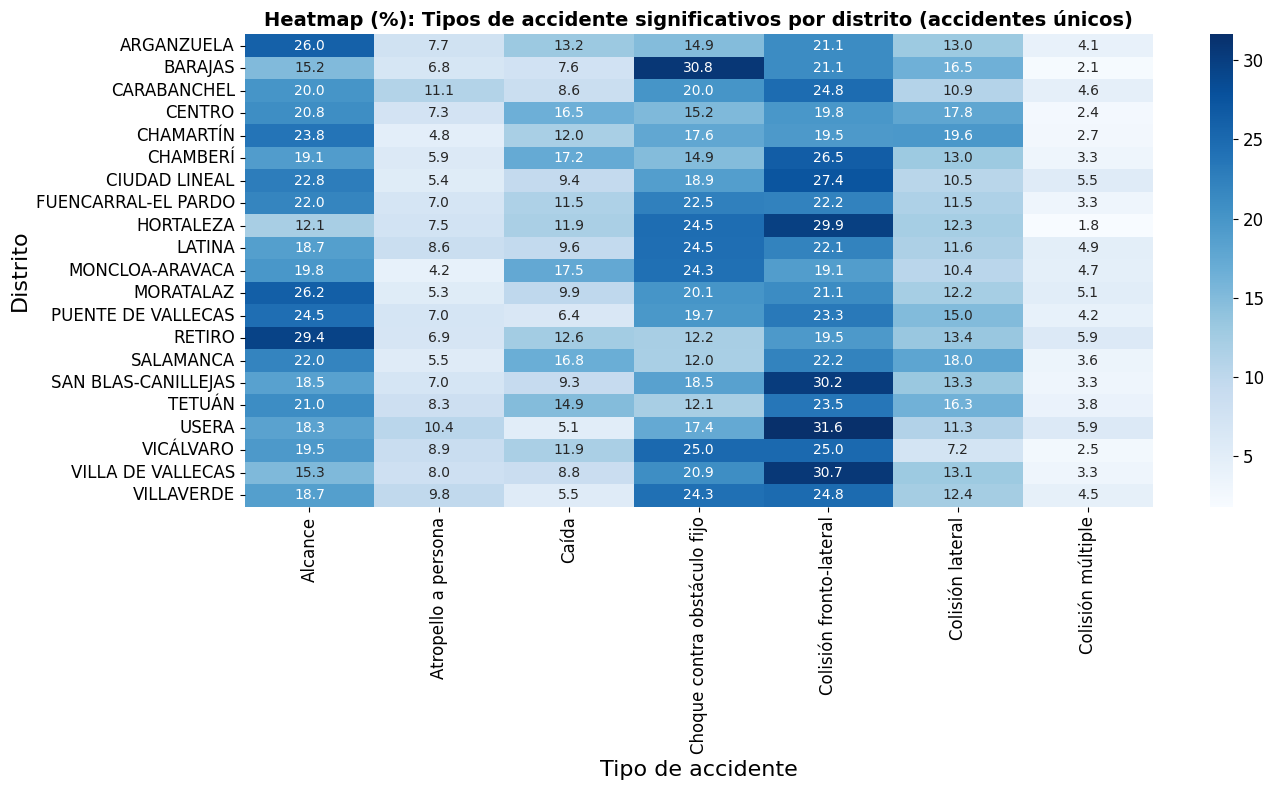

In [40]:
# 1. Definimos los tipos de accidente significativos:
tipos_significativos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

# 2. Filtramos el DataFrame original:
df_filtrado = df_20_bi[
    df_20_bi["tipo_accidente"].isin(tipos_significativos)
]

# 3. Creamos la tabla de contingencia con expedientes únicos:
tabla_contingencia = pd.crosstab(
    df_filtrado["distrito"],
    df_filtrado["tipo_accidente"],
    values=df_filtrado["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 4. Convertir a porcentajes por fila (por distrito)
tabla_porcentajes = tabla_contingencia.div(tabla_contingencia.sum(axis=1), axis=0) * 100

# 5. Dibujamos el Heatmap con frecuencias en porcentaje:
plt.figure(figsize=(14,8))
sns.heatmap(tabla_porcentajes, annot=True, fmt=".1f", cmap="Blues")
plt.title("Heatmap (%): Tipos de accidente significativos por distrito (accidentes únicos)")
plt.xlabel("Tipo de accidente")
plt.ylabel("Distrito")
plt.tight_layout()
plt.show()

¿Hay relación estadística entre distrito y tipo de accidente?

In [41]:

# 6. Lanazamos el test chi-cuadrado (se hace sobre la tabla de frecuencias absolutas):
chi2, p, dof, expected = chi2_contingency(tabla_contingencia)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 657.6807377910263
P-Value: 4.2861840229086293e-75
Grados de Libertad: 120
Tabla de Frecuencias Esperadas:
 [[123.39685145  41.30657316  68.45213758 109.01798105 138.95217489
   79.86808923  23.00619264]
 [ 50.07714691  16.76311274  27.77937775  44.24188614  56.3898381
   32.41222114   9.33641722]
 [169.88196672  56.86726852  94.23890174 150.08639857 191.29717227
  109.95538312  31.67290905]
 [147.06200104  49.22838171  81.57994479 129.92553906 165.60053719
   95.18525703  27.41833918]
 [184.67268522  61.81839887 102.44378124 163.15362232 207.95239872
  119.528613    34.43050063]
 [146.00552115  48.87472954  80.99388197 128.99216593 164.41087816
   94.5014549   27.22136835]
 [176.64343804  59.13064239  97.9897038  156.05998657 198.91099008
  114.33171678  32.93352235]
 [159.73975976  53.47220771  88.61269865 141.12601656 179.87644557
  103.39088264  29.78198911]
 [127.41147504  42.65045139  70.6791763  112.56479893 143.47287921
   82.46653734  23.75468179]
 [125.2985

Comos el test Chi-Cuadrado nos da un p-valor muy pequeño, (<< 0.05), podemos rechazar las hipótesis nula de que las variables sean independientes. Por tanto, hay una relación estadísticamente significativa.

### Análisis bivariante por resultado de test de alcoholemia

Cruzamos las variables positivo en alcohol y tipo de accidente. ¿Influye el consumo de alcohol en el tipo de accidente?

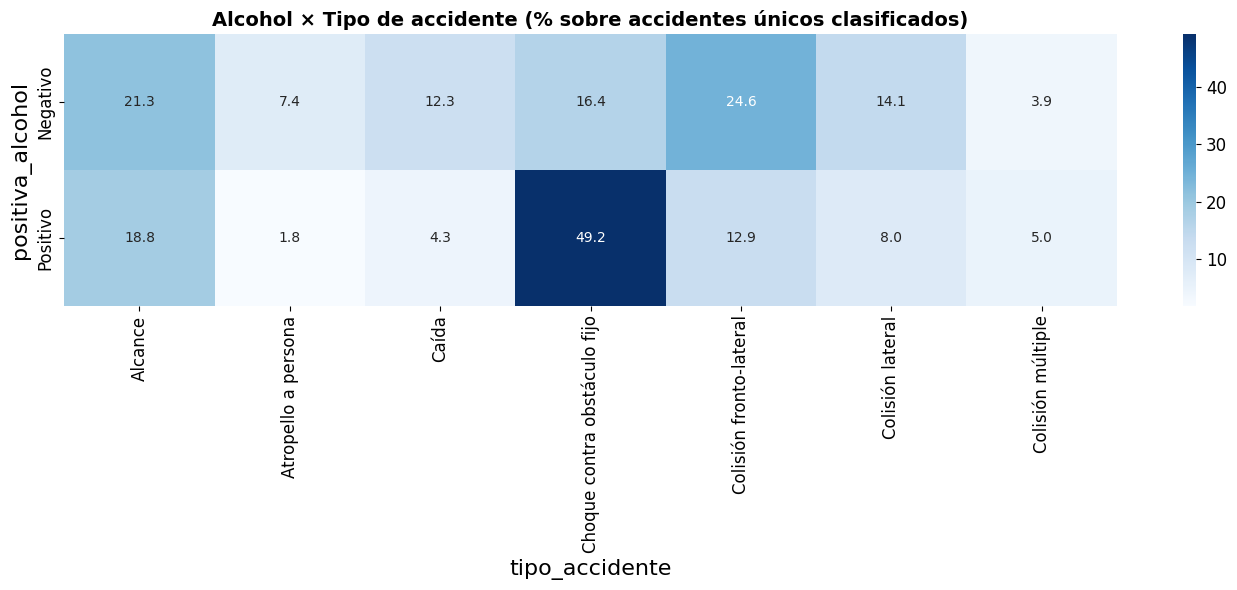

In [42]:
# 1. Filtramos el fataset po tipo de persona = conductor y seleccionamos los tipos más relevantes:
df_conductores = df_20_bi[
    (df_20_bi["tipo_persona"].str.lower() == "conductor") &
    (df_20_bi["tipo_accidente"].isin(tipos_significativos))
]

# 2. Quitamos "No consta" en alcohol:
df_conductores = df_conductores[
    df_conductores["positiva_alcohol"] != "No consta"
]

# 3. Clasificamos accidentes único en Negativo o positivo:
#    - Si algún conductor dio "Positivo" → "Positivo"
#    - Si todos dieron "Negativo" → "Negativo"
clasificacion_accidentes = (
    df_conductores
    .groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if x.str.lower().str.contains("pos", na=False).any() else "Negativo")
    .reset_index()
)

# 4. Creamos  dataset de tipo de accidente (único por expediente):
tipos_por_accidente = (
    df_conductores.groupby("num_expediente")["tipo_accidente"]
    .first()
    .reset_index()
)

# 5. Unimos clasificación y tipo de accidente:
df_accidentes_clasificados = clasificacion_accidentes.merge(
    tipos_por_accidente, on="num_expediente"
)

# 6. Tabla de contingencia (accidentes únicos)
ct = pd.crosstab(
    df_accidentes_clasificados["positiva_alcohol"],
    df_accidentes_clasificados["tipo_accidente"]
)

# 7. Convertir a porcentajes por fila
ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

# 8. Dibujamos Heatmap de porcentajes
plt.figure(figsize=(14,6))
sns.heatmap(ct_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Alcohol × Tipo de accidente (% sobre accidentes únicos clasificados)")
plt.tight_layout()
plt.show()

¿Hay relación estadística entre el consumo de alcohol y el tipo de accidente?

In [43]:
# 9. Realizamos test Chi-cuadrado (con tabla absoluta):
chi2, p, dof, expected = chi2_contingency(ct)

print("Chi-cuadrado:", chi2)
print("p-value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)

Chi-cuadrado: 662.5085673233286
p-value: 7.585908763586008e-140
Grados de Libertad: 6
Tabla de Frecuencias Esperadas:
 [[2635.93846154  876.78461538 1462.23846154 2322.26923077 2968.22307692
  1706.1         491.44615385]
 [ 196.06153846   65.21538462  108.76153846  172.73076923  220.77692308
   126.9          36.55384615]]


Podemos decir con confianza que existe una relación estadísticamente significativa entre ambas variables (p-value << 0.05).

Cruzamos las variables positivo en alcohol y lesividad. ¿Cómo se distribuyen los conductores con alcohol positivo y negativo según el grado de lesividad?

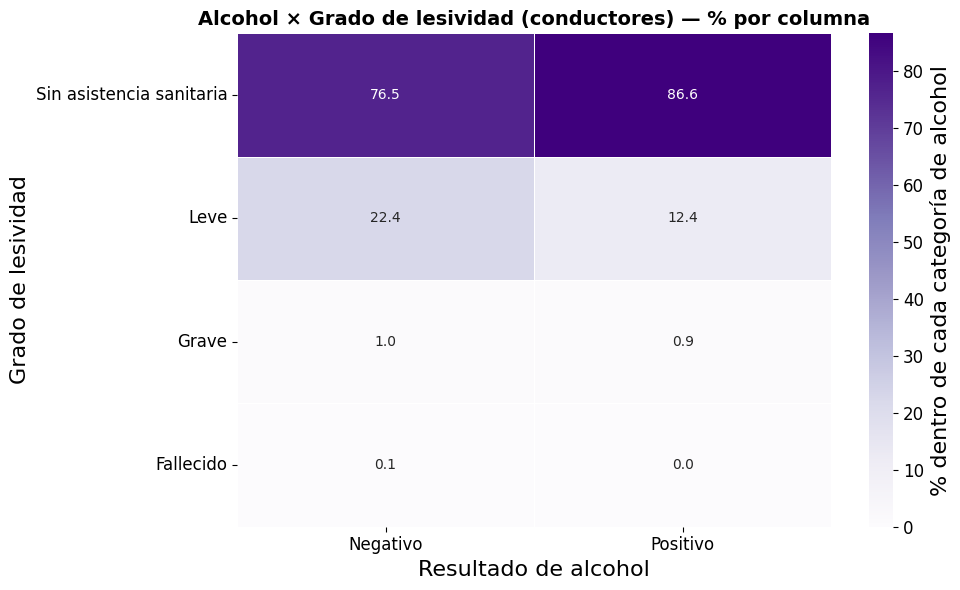

TEST CHI-CUADRADO
Valor Chi-Cuadrado: 55.38086461492463
P-Value: 5.694528803037329e-12
Grados de Libertad: 3

Frecuencias Esperadas:

positiva_alcohol              Negativo    Positivo
lesividad                                         
Sin asistencia sanitaria  18524.362170  748.637830
Leve                       5299.814923  214.185077
Grave                       232.599784    9.400216
Fallecido                    19.223123    0.776877


In [44]:
# 1. Filtramos el dataset solo por CONDUCTORES:
df_conductores = df_20_bi.copy()
df_conductores = df_conductores[df_conductores["tipo_persona"].str.lower() == "conductor"]

# 2. Limpiamos los datos:
rangos_menores = ["De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años"]
df_conductores = df_conductores[~df_conductores["rango_edad"].isin(rangos_menores)]
df_conductores = df_conductores[df_conductores["positiva_alcohol"] != "No consta"]
df_conductores = df_conductores[df_conductores["rango_edad"] != "Desconocido"]

# 3. Creamos tabla de frecuencias absoluta: grado de lesividad × alcohol
tabla_abs = pd.crosstab(
    df_conductores["lesividad"],
    df_conductores["positiva_alcohol"],
)

# 4. Tabla porcentual para heatmap
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

orden_grado = [
    "Sin asistencia sanitaria",
    "Leve",
    "Grave",
    "Fallecido"
]

tabla_abs = tabla_abs.reindex(orden_grado)
tabla_pct = tabla_pct.reindex(orden_grado)

# 5. Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada categoría de alcohol"}
)

plt.title("Alcohol × Grado de lesividad (conductores) — % por columna")
plt.xlabel("Resultado de alcohol")
plt.ylabel("Grado de lesividad")
plt.tight_layout()
plt.show()

# 6. Test Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("TEST CHI-CUADRADO")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)

# Convertir esperadas a DataFrame con índices y columnas correctas
expected_df = pd.DataFrame(
    expected,
    index=tabla_abs.index,
    columns=tabla_abs.columns
)

print("\nFrecuencias Esperadas:\n")
print(expected_df)

In [45]:
tabla_abs

positiva_alcohol          Negativo  Positivo
lesividad                                   
Sin asistencia sanitaria     18430       843
Leve                          5393       121
Grave                          233         9
Fallecido                       20         0

Pese al valor de p no ser muy pequeño, esta debajo de 0.05, indicando cierta relación estdística entre grado de lesividad y resultado de alcohol.

### Análisis bivariante demográfico

En primer lugar, cruzamos rango de edad con positivo en alcohol. ¿Cómo se distribuyen los accidentes con  positivo en alcohol según la edad del conductor?

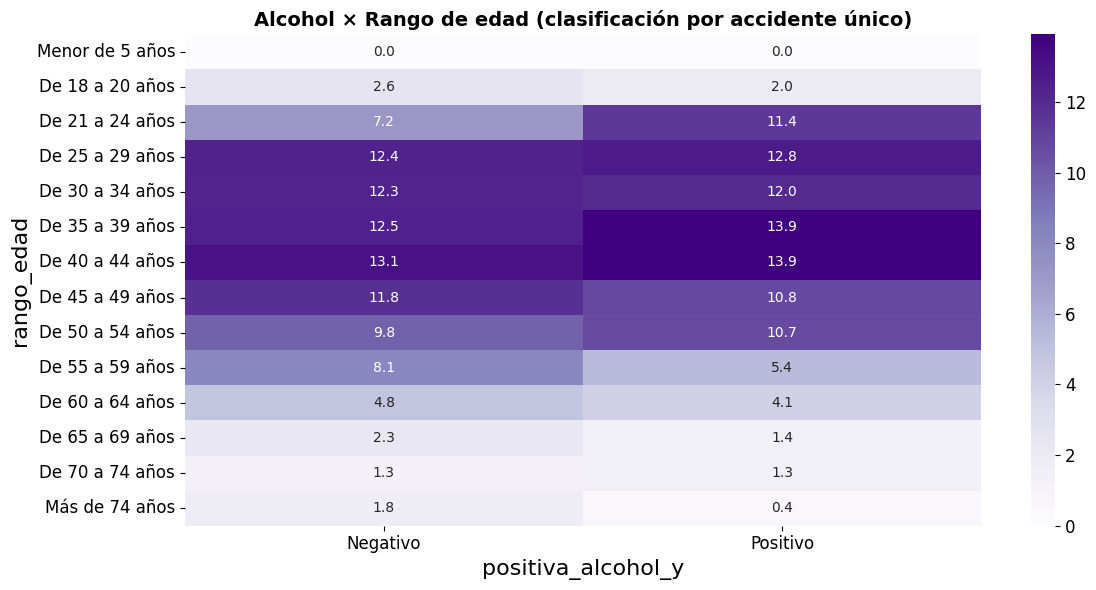

In [46]:
# 1. Filtramos el dataset por conductores
df_conductores = df_20_bi[
    df_20_bi["tipo_persona"].str.lower() == "conductor"
].copy()

# 2. Eliminamos menores de edad:
rangos_menores = ["De 6 a 9 años", "De 10 a 14 años", "De 15 a 17 años"]
df_conductores = df_conductores[~df_conductores["rango_edad"].isin(rangos_menores)]

# 3. Eliminamos positiva_alcohol = "No consta"
df_conductores = df_conductores[df_conductores["positiva_alcohol"] != "No consta"]

# 4. Eliminamos rango_edad desconocido
df_conductores = df_conductores[df_conductores["rango_edad"] != "Desconocido"]

# 5. Clasificamos accidentes según alcohol
# Si algún conductor del accidente dio positivo → accidente positivo
clasificacion_accidente = (
    df_conductores.groupby("num_expediente")["positiva_alcohol"]
    .apply(lambda x: "Positivo" if (x == "Positivo").any() else "Negativo")
    .reset_index()
)

# 6. Añadimos la clasificación al dataframe de conductores
df_conductores = df_conductores.merge(clasificacion_accidente, on="num_expediente")

# 7. Creamos Tabla de contingencia: Rango de edad × Alcohol (por accidente único)
tabla_edad_alcohol = pd.crosstab(
    df_conductores["rango_edad"],
    df_conductores["positiva_alcohol_y"],  # columna creada por el merge
    values=df_conductores["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

# 8. Normalizamos por columna (cada columna = 100%)
tabla_edad_alcohol_pct = tabla_edad_alcohol.div(
    tabla_edad_alcohol.sum(axis=0), axis=1
) * 100

# 9. Dibujamos el Heatmap:
plt.figure(figsize=(12,6))
sns.heatmap(tabla_edad_alcohol_pct, annot=True, fmt=".1f", cmap="Purples")
plt.title("Alcohol × Rango de edad (clasificación por accidente único)")
plt.tight_layout()
plt.show()

¿Existe una relación estadísticamente significativa entre el rango de edad y el alcohol en accidentes?

In [47]:
# 10. Realizamos el test de Chi-cuadrado sobre tabla absoluta
chi2, p, dof, expected = chi2_contingency(tabla_edad_alcohol)

print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Frecuencias Esperadas:\n", expected)

Valor Chi-Cuadrado: 70.36081203010772
P-Value: 6.88807785740867e-10
Grados de Libertad: 13
Frecuencias Esperadas:
 [[9.35733246e-01 6.42667536e-02]
 [5.13717552e+02 3.52824477e+01]
 [1.50559479e+03 1.03405207e+02]
 [2.50121497e+03 1.71785032e+02]
 [2.47407870e+03 1.69921297e+02]
 [2.52367257e+03 1.73327434e+02]
 [2.64438215e+03 1.81617846e+02]
 [2.36085498e+03 1.62145019e+02]
 [1.98094728e+03 1.36052717e+02]
 [1.59261799e+03 1.09382015e+02]
 [9.52576445e+02 6.54235552e+01]
 [4.42601826e+02 3.03981745e+01]
 [2.55455176e+02 1.75448237e+01]
 [3.44349835e+02 2.36501653e+01]]


En este caso el valor de p no es tan pequeño como en el caso anterior, pero se puede afirmar que existe una relación estadísticamente significativa entre ambas variables.

Ahora, cruzamos el tipo de persona con el grado de lesividad:

Tabla absoluta:
lesividad     Grave  Leve  Sin asistencia sanitaria
tipo_persona                                       
Conductor       248  5584                     19418
Pasajero         24  1363                      3183
Peatón          136   800                       150

Tabla en porcentaje (% por columna):
lesividad     Grave  Leve  Sin asistencia sanitaria
tipo_persona                                       
Conductor      60.8  72.1                      85.4
Pasajero        5.9  17.6                      14.0
Peatón         33.3  10.3                       0.7


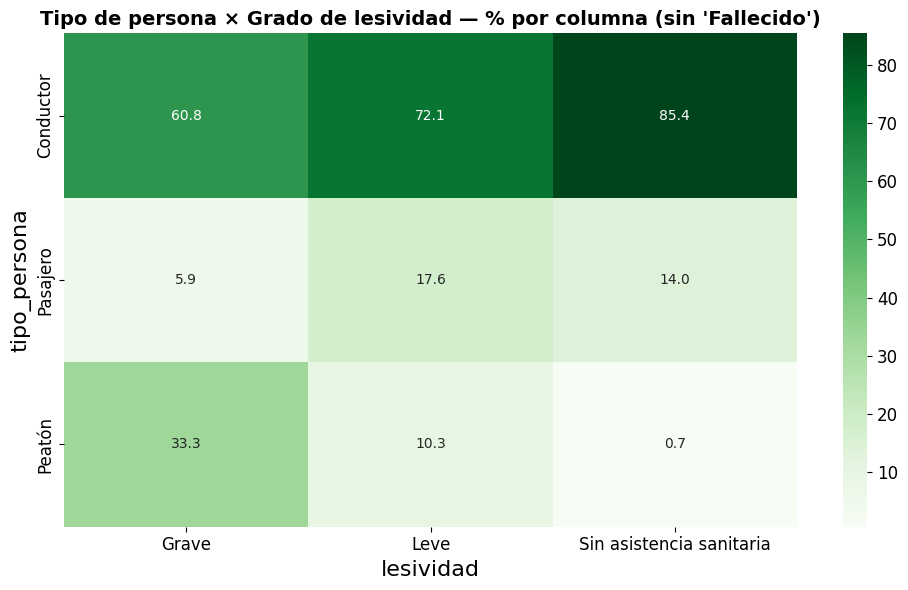


--- Chi-cuadrado ---
Chi2: 2802.928537801663
p-value: 0.0
Grados de libertad: 4
Frecuencias esperadas:
 [[3.33333333e+02 6.32924837e+03 1.85874183e+04]
 [6.03300330e+01 1.14553129e+03 3.36413868e+03]
 [1.43366337e+01 2.72220346e+02 7.99443021e+02]]


In [48]:
# Hacemos una copia del dataframe
df = df_20_bi.copy()

# 1. Eliminamos registros sin lesividad válida:
df = df[df["lesividad"] != "Se desconoce"]

# 2. Eliminamos fallecidos:
df = df[df["lesividad"] != "Fallecido"]

# 3. Creamos tabla de contingencia absoluta (PERSONAS)
tabla_abs = pd.crosstab(
    df["tipo_persona"],
    df["lesividad"]
)

print("Tabla absoluta:")
print(tabla_abs)

# 4. Creamos tabla de frecuencias relativas:
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100
print("\nTabla en porcentaje (% por columna):")
print(tabla_pct.round(1))

# 5. Dibujamos heatmap:
plt.figure(figsize=(10,6))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Greens")
plt.title("Tipo de persona × Grado de lesividad — % por columna (sin 'Fallecido')")
plt.tight_layout()
plt.show()

# 6. Realizamos el test de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)
print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)

Obtenemos un valor de p menos a 0.05 por lo que hay relación estdísticamente siginicativa.

Finalmente, cruzamos las variables rango de edad y lesividad:

Tabla absoluta:
lesividad        Grave  Leve  Sin asistencia sanitaria
rango_edad                                            
De 18 a 20 años      7   303                       621
De 21 a 24 años     21   694                      1456
De 25 a 29 años     47  1130                      2204
De 30 a 34 años     45  1045                      2228
De 35 a 39 años     42   890                      2356
De 40 a 44 años     38   854                      2475
De 45 a 49 años     39   686                      2317
De 50 a 54 años     34   551                      1937
De 55 a 59 años     27   463                      1573
De 60 a 64 años     25   255                       983
De 65 a 69 años     19   131                       485
De 70 a 74 años     13   115                       299
Más de 74 años      31   219                       398


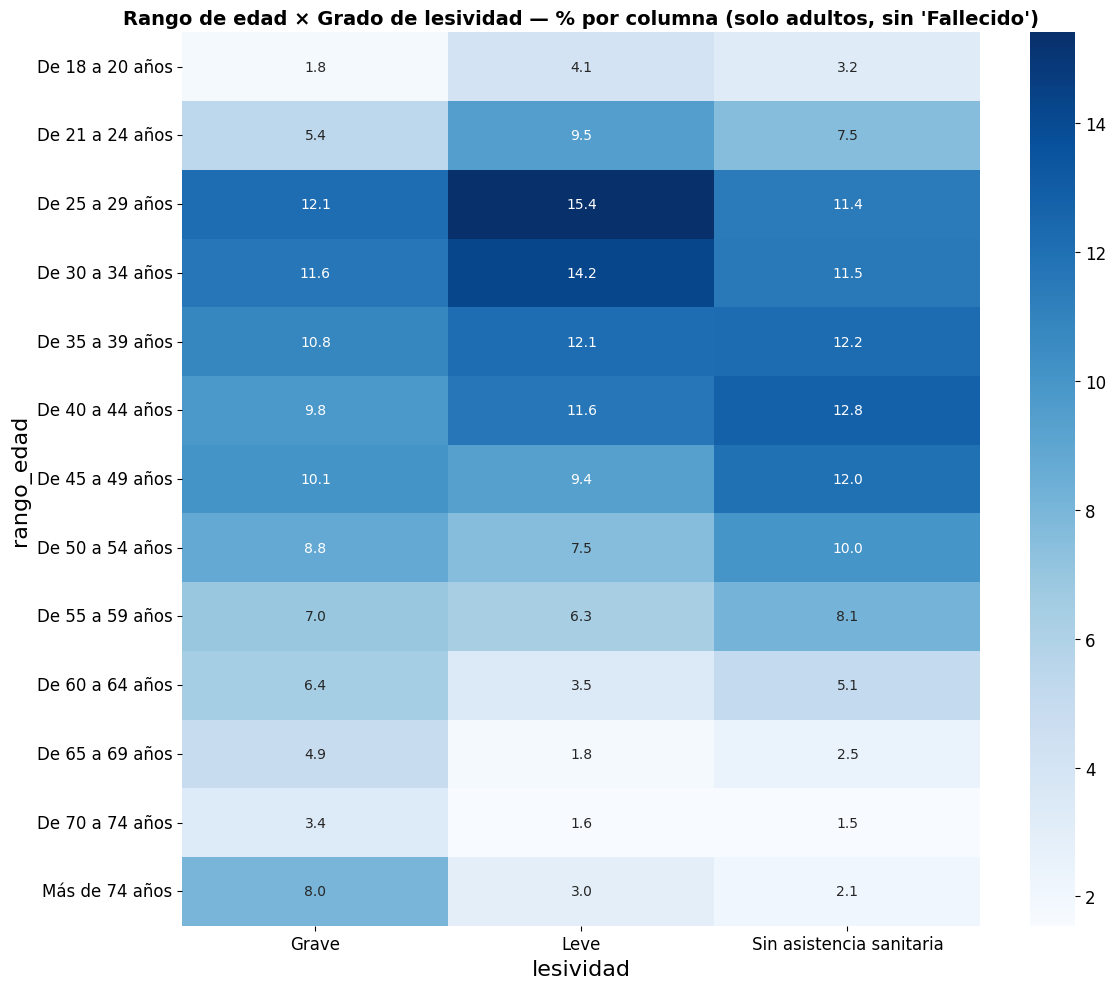

In [49]:
# Copiamos el dataframe
df = df_20_bi.copy()

# 1. Eliminamos los registros sin lesividad válida:
df = df[df["lesividad"] != "Se desconoce"]

# 2. Eliminamos los fallecidos:
df = df[df["lesividad"] != "Fallecido"]

# 3. Eliminamos las edades desconocidas:
df = df[df["rango_edad"] != "Desconocido"]

# 4. Eliminamos los menores de 18 años:
rangos_menores = [
    "Menor de 5 años",
    "De 6 a 9 años",
    "De 10 a 14 años",
    "De 15 a 17 años"
]
df = df[~df["rango_edad"].isin(rangos_menores)]

# 5. Orden correcto de los rangos de edad (solo adultos):
orden_edades_adultos = [
    "De 18 a 20 años",
    "De 21 a 24 años",
    "De 25 a 29 años",
    "De 30 a 34 años",
    "De 35 a 39 años",
    "De 40 a 44 años",
    "De 45 a 49 años",
    "De 50 a 54 años",
    "De 55 a 59 años",
    "De 60 a 64 años",
    "De 65 a 69 años",
    "De 70 a 74 años",
    "Más de 74 años"
]
df["rango_edad"] = pd.Categorical(df["rango_edad"], categories=orden_edades_adultos, ordered=True)

# 6. Creamos tabla de frecuencias absolutas:
tabla_abs = pd.crosstab(df["rango_edad"], df["lesividad"])
print("Tabla absoluta:")
print(tabla_abs)

# 7. Creamos tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 8. Dibujamos el heatmap
plt.figure(figsize=(12,10))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Rango de edad × Grado de lesividad — % por columna (solo adultos, sin 'Fallecido')")
plt.tight_layout()
plt.show()

In [50]:
# 9. Realizamos el test de Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla_abs)
print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)


--- Chi-cuadrado ---
Chi2: 379.1861954690573
p-value: 1.3850508702596946e-65
Grados de libertad: 24
Frecuencias esperadas:
 [[  13.3511236   252.43258427  665.21629213]
 [  31.13350089  588.64784151 1551.2186576 ]
 [  48.48565937  916.72885866 2415.78548196]
 [  47.58219988  899.64695446 2370.77084565]
 [  47.15198108  891.51271437 2349.33530455]
 [  48.2848906   912.93287995 2405.78222945]
 [  43.62418687  824.81194559 2173.56386753]
 [  36.16706091  683.81845062 1802.01448847]
 [  29.58471319  559.36457717 1474.05070964]
 [  18.11221171  342.45150798  902.43628031]
 [   9.10629805  172.17474867  453.71895328]
 [   6.12344766  115.77735068  305.09920166]
 [   9.2927262   175.69958604  463.00768776]]


p-value = 1.38 e-65 --> hay relación estadísticamente significativa entre rango edad y lesividad

### Análisis bivariante por factores que afectan al accidente

Cruzamos tipo de accidente por grado de lesividad:

Tabla absoluta:


lesividad                     Fallecido  Grave  Leve  Sin asistencia sanitaria
tipo_accidente                                                                
Alcance                               2     32  1660                      5443
Atropello a persona                  13    138   864                      1100
Caída                                 3     54  1433                       618
Choque contra obstáculo fijo          5     37   412                      3638
Colisión fronto-lateral               4     97  2126                      5613
Colisión lateral                      2     15   594                      3646
Colisión múltiple                     1     13   353                      1568

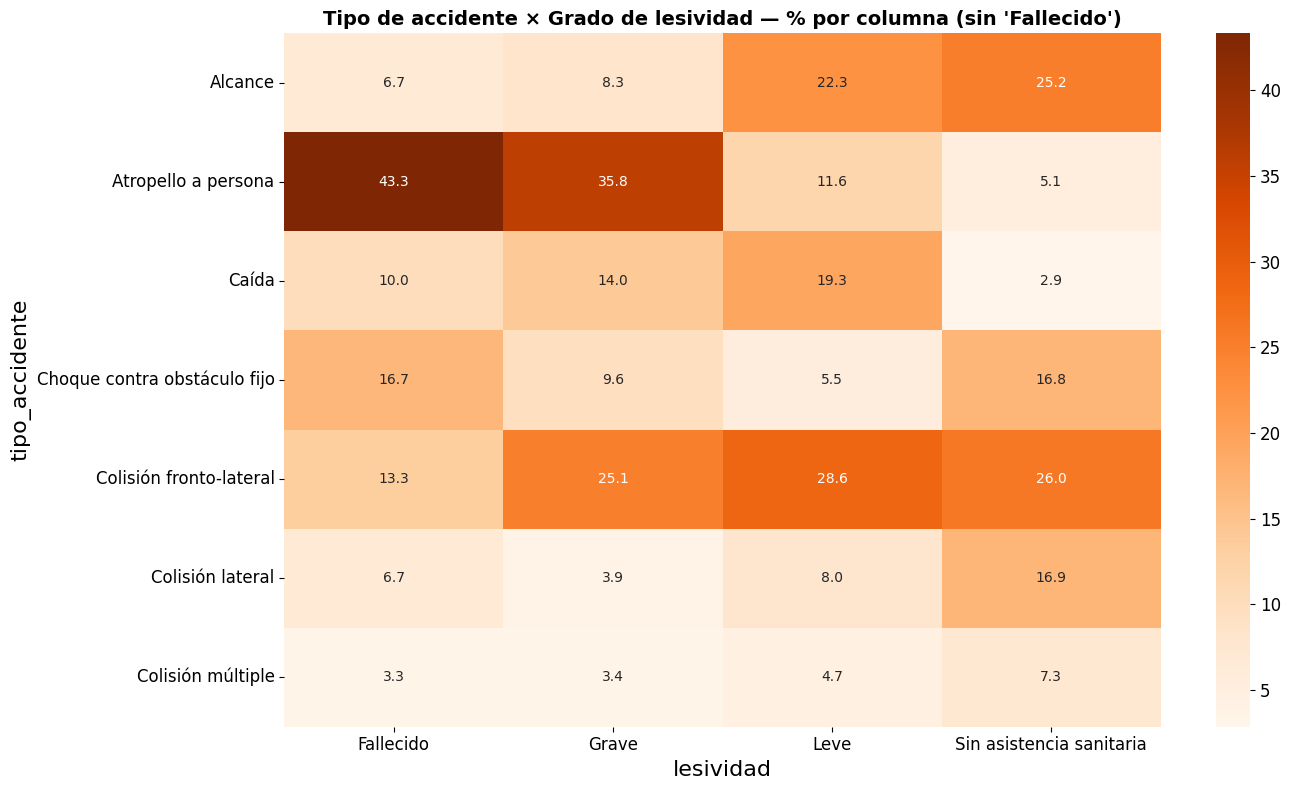


--- Chi-cuadrado ---
Chi2: 3924.800839774667
p-value: 0.0
Grados de libertad: 18
Frecuencias esperadas:
 [[7.26190476e+00 9.34365079e+01 1.80143651e+03 5.23486508e+03]
 [2.15201465e+00 2.76892552e+01 5.33843101e+02 1.55131563e+03]
 [2.14489214e+00 2.75976123e+01 5.32076245e+02 1.54618125e+03]
 [4.16361416e+00 5.35718356e+01 1.03285389e+03 3.00141066e+03]
 [7.97720798e+00 1.02640076e+02 1.97887939e+03 5.75050332e+03]
 [4.33150183e+00 5.57319902e+01 1.07450122e+03 3.12243529e+03]
 [1.96886447e+00 2.53327228e+01 4.88409646e+02 1.41928877e+03]]


In [51]:
# Hacemos una copia del dataframe:
df = df_20_bi.copy()

# 1. Eliminamos los registros sin lesividad válida:
df = df[df["lesividad"] != "Se desconoce"]

# 2. Mantenemos SOLO los 7 tipos de accidente seleccionados:
tipos_validos = [
    "Colisión fronto-lateral",
    "Alcance",
    "Colisión lateral",
    "Choque contra obstáculo fijo",
    "Caída",
    "Atropello a persona",
    "Colisión múltiple"
]

df = df[df["tipo_accidente"].isin(tipos_validos)]

# 3. Ordenamos las categorías de lesividad con fallecio
orden_lesividad = [
    "Fallecido",
    "Grave",
    "Leve",
    "Sin asistencia sanitaria"
]

df["lesividad"] = pd.Categorical(df["lesividad"],
                                       categories=orden_lesividad,
                                       ordered=True)

# 4. Creamos la tabla de frecuencias absolutas:
tabla_abs = pd.crosstab(
    df["tipo_accidente"],
    df["lesividad"]
)

print("Tabla absoluta:")
display(tabla_abs)

# 5. Creamos la tabla porcentual por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 6. Dibujamos Heatmap:
plt.figure(figsize=(14,8))
sns.heatmap(tabla_pct, annot=True, fmt=".1f", cmap="Oranges")
plt.title("Tipo de accidente × Grado de lesividad — % por columna (sin 'Fallecido')")
plt.tight_layout()
plt.show()

# 7. Realizamos el test de Chi-cuadrado:
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Chi-cuadrado ---")
print("Chi2:", chi2)
print("p-value:", p)
print("Grados de libertad:", dof)
print("Frecuencias esperadas:\n", expected)

In [52]:
# Compruebo si al menos el 80% de celdas tienen una frecuencia esperada mayor o igual que 5

df_expected = pd.DataFrame(
    expected,
    index=tabla_abs.index,
    columns=tabla_abs.columns
)

porcentaje = (df_expected >= 5).sum().sum() / df_expected.size * 100
print(porcentaje)

82.14285714285714


El test chi-cuadrado revela que hay relación estadística.

### Análisis bivariante temporal

Cruzamos las variables franja horaria y lesividad. ¿Cómo se distribuyen los ACCIDENTES según su gravedad en cada franja horaria?

Tabla absoluta:


lesividad  Fallecido  Grave    Leve  Sin asistencia sanitaria
franja                                                       
Madrugada        6.0   36.0   360.0                    1064.0
Mañana           8.0  100.0  1412.0                    2602.0
Tarde           10.0  124.0  2427.0                    4598.0
Noche           10.0  134.0  2252.0                    4224.0

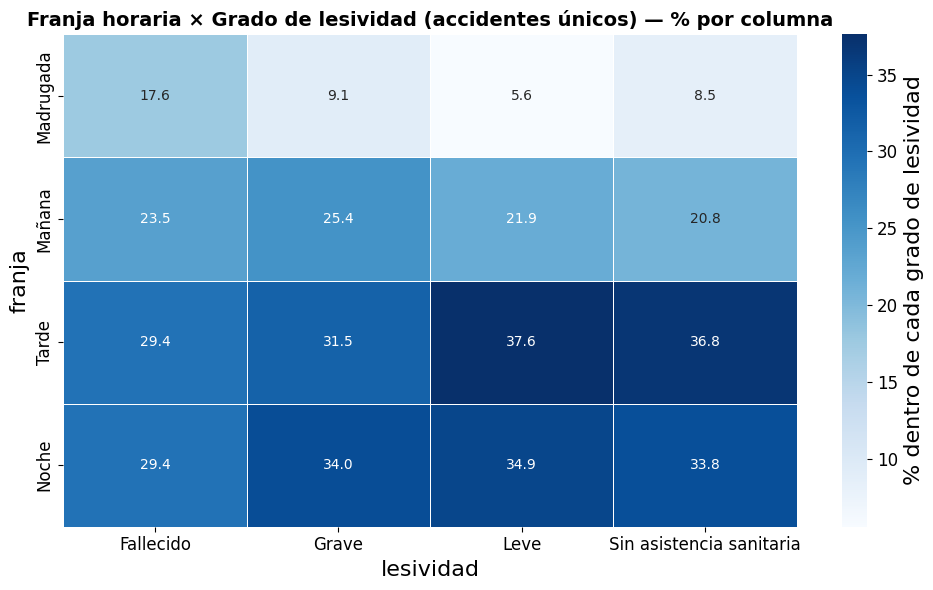


--- Resultados Chi-cuadrado ---
Valor Chi-Cuadrado: 66.19712127692186
P-Value: 8.435081113812551e-11
Grados de Libertad: 9

Frecuencias Esperadas:
 [[2.57365622e+00 2.98241338e+01 4.88313420e+02 9.45288790e+02]
 [7.23643311e+00 8.38574895e+01 1.37300676e+03 2.65789931e+03]
 [1.25680797e+01 1.45641865e+02 2.38460830e+03 4.61618175e+03]
 [1.16218309e+01 1.34676512e+02 2.20507151e+03 4.26863014e+03]]


In [53]:
# 1. Realizamos copia del dataset:
df = df_20_bi.copy()

# 2. Creamos columna de hora a patir de la variable fecha_hora (datetime): 
df["hora"] = df["fecha_hora"].dt.hour

# 3. Creamos franja horaria: 
df["franja"] = pd.cut(
    df["hora"],
    bins=[0, 6, 12, 18, 24],
    labels=["Madrugada", "Mañana", "Tarde", "Noche"],
    right=False
)

# 4. Eliminamos categoría "Se desconoce" en lesividad: 
df = df[df["lesividad"] != "Se desconoce"]

# 5. Creamos la Tabla de frecuencias absolutas: Franja × Grado de lesividad (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja"],
    df["lesividad"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

print("Tabla absoluta:")
display(tabla_abs)

# 6. Convertimos la tabla a porcentajes por columna (cada columna suma 100%)
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 7. Dibujamos el Heatmap con frecuencias en porcentaje:
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada grado de lesividad"}
)

plt.title("Franja horaria × Grado de lesividad (accidentes únicos) — % por columna")
plt.tight_layout()
plt.show()

# 8. Realizamos el test Chi-cuadrado (siempre con tabla absoluta):
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Resultados Chi-cuadrado ---")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("\nFrecuencias Esperadas:\n", expected)

In [54]:
# Comprobamos si al menos el 80% de celdas tienen una frecuencia esperada mayor o igual que 5

df_expected = pd.DataFrame(
    expected,
    index=tabla_abs.index,
    columns=tabla_abs.columns
)

porcentaje = (df_expected >= 5).sum().sum() / df_expected.size * 100
print(porcentaje)

93.75


p-value <<< 0.05 por lo que existe relación estadísticamente significativa. 

Ahora cruzamos las variables franja horaria con positivo alcohol:

Tabla absoluta:


alcohol_accidente  Negativo  Positivo
franja                               
Madrugada               888       333
Mañana                 2870       113
Tarde                  5071        91
Noche                  4353       436

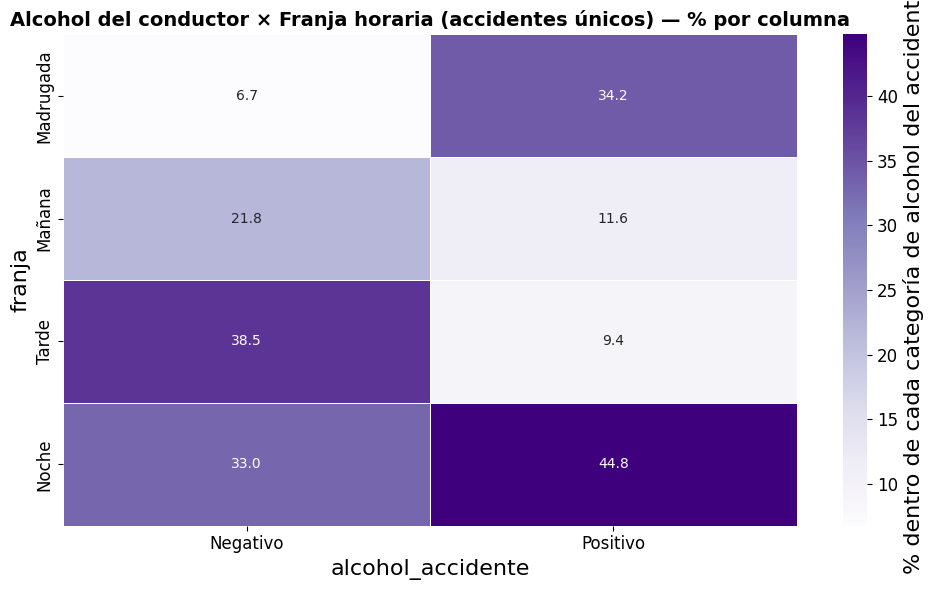


--- Resultados Chi-cuadrado ---
Valor Chi-Cuadrado: 1085.9245694172369
P-Value: 4.118273072701443e-235
Grados de Libertad: 3

Frecuencias Esperadas:
 [[1137.06972801   83.93027199]
 [2777.95167785  205.04832215]
 [4807.16948075  354.83051925]
 [4459.80911339  329.19088661]]


In [55]:
# 1. Realizamos copia del dataset: 
df = df_20_bi.copy()

# 2. Filtramos alcohol registrado (opcional pero recomendable)
df = df[df["positiva_alcohol"] != "No consta"]

# 3. Creamos columna hora desde la variable fecha_hora :
df["hora"] = df["fecha_hora"].dt.hour

# 4. Crear franja horaria 
df["franja"] = pd.cut(
    df["hora"],
    bins=[0, 6, 12, 18, 24],
    labels=["Madrugada", "Mañana", "Tarde", "Noche"],
    right=False
)

# 5. Filtramos solo conductores para clasificar el accidente:
df_cond = df[df["tipo_persona"].str.lower() == "conductor"]

# 6. Clasificamos accidente según alcohol del conductor:
alcohol_accidente = df_cond.groupby("num_expediente")["positiva_alcohol"].apply(
    lambda x: "Positivo" if "Positivo" in x.values else "Negativo"
).reset_index().rename(columns={"positiva_alcohol": "alcohol_accidente"})

# 7. Unimos clasificación al dataframe original
df = df.merge(alcohol_accidente, on="num_expediente", how="left")

# 8. Creamos tabla absoluta: Alcohol del accidente × Franja (accidentes únicos)
tabla_abs = pd.crosstab(
    df["franja"],
    df["alcohol_accidente"],
    values=df["num_expediente"],
    aggfunc=lambda x: x.nunique()
).fillna(0)

print("Tabla absoluta:")
display(tabla_abs)

# 9. Convertimos a porcentajes por columna
tabla_pct = tabla_abs.div(tabla_abs.sum(axis=0), axis=1) * 100

# 10. Dibujamos el heatmap en porcentaje:
plt.figure(figsize=(10,6))
sns.heatmap(
    tabla_pct,
    annot=True,
    fmt=".1f",
    cmap="Purples",
    linewidths=.5,
    cbar_kws={"label": "% dentro de cada categoría de alcohol del accidente"}
)

plt.title("Alcohol del conductor × Franja horaria (accidentes únicos) — % por columna")
plt.tight_layout()
plt.show()

# 11. Realizamos el test Chi-cuadrado (sobre tabla absoluta):
chi2, p, dof, expected = chi2_contingency(tabla_abs)

print("\n--- Resultados Chi-cuadrado ---")
print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("\nFrecuencias Esperadas:\n", expected)

El test Chi-cuadrado confirma que la franja horaria influye en la presencia del alcohol en conductores.

## Análisis multivariante

In [56]:
#Hacemos copia del dataframe
df_20_multi=df_20_bi.copy()

In [57]:
df_20_multi.loc[df_20_multi.coordenada_y_utm == "#¡VALOR!"]

num_expediente      fecha      hora  \
17953    2020s011111 2020-08-09  18:10:00   
17954    2020s011111 2020-08-09  18:10:00   
17955    2020s011111 2020-08-09  18:10:00   
20493    2020s012560 2020-09-13  17:45:00   
20494    2020s012560 2020-09-13  17:45:00   
20495    2020s012560 2020-09-13  17:45:00   

                              localizacion numero            distrito  \
17953                 call. polvoranca, 13     13         CARABANCHEL   
17954                 call. polvoranca, 13     13         CARABANCHEL   
17955                 call. polvoranca, 13     13         CARABANCHEL   
20493  avda. albufera / avda. pablo neruda    273  PUENTE DE VALLECAS   
20494  avda. albufera / avda. pablo neruda    273  PUENTE DE VALLECAS   
20495  avda. albufera / avda. pablo neruda    273  PUENTE DE VALLECAS   

                     tipo_accidente estado_meteorológico tipo_vehiculo  \
17953  Choque contra obstáculo fijo            Despejado     No consta   
17954  Choque contra obstáculo fijo            Despejado     Furgoneta   
17955  Choque contra obstáculo fijo            Despejado       Turismo   
20493       Colisión fronto-lateral            Despejado       Turismo   
20494       Colisión fronto-lateral            Despejado       Turismo   
20495       Colisión fronto-lateral            Despejado       Turismo   

      tipo_persona       rango_edad         sexo                 lesividad  \
17953    Conductor              NaN  Desconocido  Sin asistencia sanitaria   
17954    Conductor              NaN  Desconocido  Sin asistencia sanitaria   
17955    Conductor              NaN  Desconocido  Sin asistencia sanitaria   
20493    Conductor  De 30 a 34 años       Hombre  Sin asistencia sanitaria   
20494    Conductor  De 40 a 44 años        Mujer  Sin asistencia sanitaria   
20495     Pasajero  De 25 a 29 años       Hombre  Sin asistencia sanitaria   

      coordenada_x_utm coordenada_y_utm positiva_alcohol          fecha_hora  \
17953         #¡VALOR!         #¡VALOR!         Negativo 2020-08-09 18:10:00   
17954         #¡VALOR!         #¡VALOR!         Negativo 2020-08-09 18:10:00   
17955         #¡VALOR!         #¡VALOR!         Negativo 2020-08-09 18:10:00   
20493         #¡VALOR!         #¡VALOR!         Negativo 2020-09-13 17:45:00   
20494         #¡VALOR!         #¡VALOR!         Negativo 2020-09-13 17:45:00   
20495         #¡VALOR!         #¡VALOR!         Negativo 2020-09-13 17:45:00   

      franja_horaria                    localizacion_norm numero_norm  
17953          Noche                 call. polvoranca, 13          13  
17954          Noche                 call. polvoranca, 13          13  
17955          Noche                 call. polvoranca, 13          13  
20493          Tarde  avda. albufera / avda. pablo neruda         273  
20494          Tarde  avda. albufera / avda. pablo neruda         273  
20495          Tarde  avda. albufera / avda. pablo neruda         273

C:\Users\aquin\AppData\Local\Temp\ipykernel_18936\738178806.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  .apply(lambda x: x.unary_union.centroid)


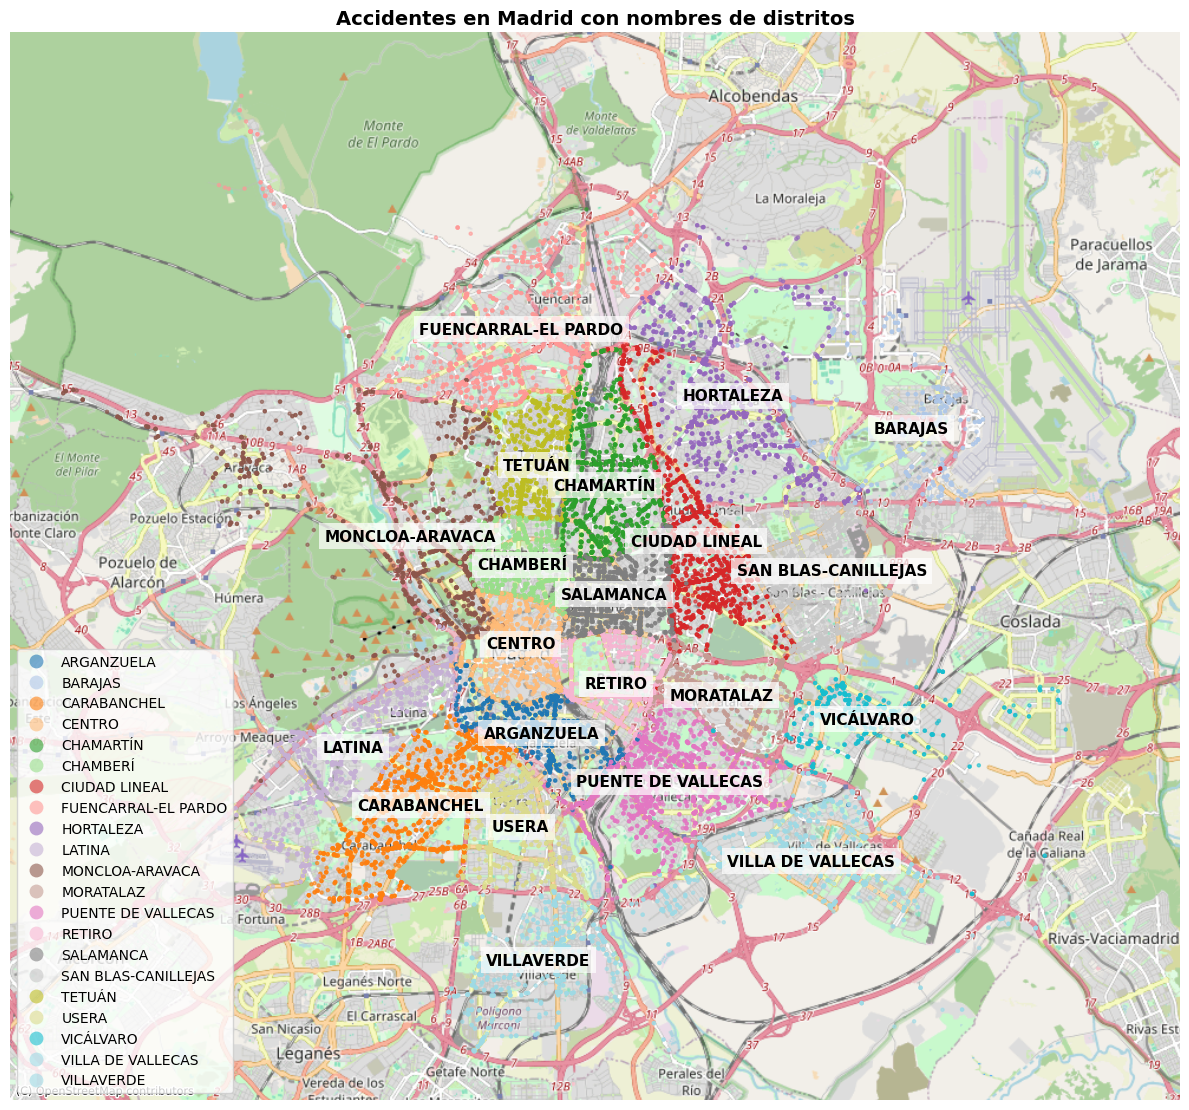

In [59]:
# 1. Convertimos el dataframe a GeoDataFrame:
df = df_20_multi.copy()

# Convertimos a numérico, los errores (como '#¡VALOR!') se vuelven NaN
df_20_multi['coordenada_x_utm'] = pd.to_numeric(df_20_multi['coordenada_x_utm'], errors='coerce')
df_20_multi['coordenada_y_utm'] = pd.to_numeric(df_20_multi['coordenada_y_utm'], errors='coerce')

# Eliminamos las filas que ahora tienen NaN en las coordenadas
df_20_multi = df_20_multi.dropna(subset=['coordenada_x_utm', 'coordenada_y_utm'])

gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["coordenada_x_utm"], df["coordenada_y_utm"]),
    crs="EPSG:25830"
)

# 2. Reproyectamos a Web Mercator:
gdf_web = gdf.to_crs(epsg=3857)

# 3. Calculamos el centro aproximado de cada distrito:
centros = (
    gdf_web.groupby("distrito", observed = False)["geometry"]
    .apply(lambda x: x.unary_union.centroid)
    .reset_index()
)

# 4. Creamos el mapa con colores por distrito:
fig, ax = plt.subplots(figsize=(12, 16))

gdf_web.plot(
    ax=ax,
    column="distrito",
    markersize=5,
    alpha=0.6,
    legend=True,
    categorical=True,
    cmap="tab20"
)

# 5. Añadimos mapa base:
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=12
)

# 6. Añadimos los nombres de los distritos:
for _, row in centros.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        row["distrito"],
        fontsize=11,
        fontweight="bold",
        color="black",
        ha="center",
        va="center",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

# 7. Ajustes finales
ax.set_title("Accidentes en Madrid con nombres de distritos")
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [60]:
# 1. Superficie oficial de los 21 distritos de Madrid (km²)
superficie_distritos = {
    "CENTRO": 5.23,
    "ARGANZUELA": 6.46,
    "RETIRO": 5.47,
    "SALAMANCA": 5.38,
    "CHAMARTÍN": 5.99,
    "TETUÁN": 5.38,
    "CHAMBERÍ": 4.69,
    "FUENCARRAL-EL PARDO": 237.81,
    "MONCLOA-ARAVACA": 46.65,
    "LATINA": 25.41,
    "CARABANCHEL": 14.76,
    "USERA": 7.75,
    "PUENTE DE VALLECAS": 14.89,
    "MORATALAZ": 6.34,
    "CIUDAD LINEAL": 11.43,
    "HORTALEZA": 27.41,
    "VILLAVERDE": 20.29,
    "VILLA DE VALLECAS": 48.34,
    "VICÁLVARO": 14.40,
    "SAN BLAS-CANILLEJAS": 22.36,
    "BARAJAS": 41.94
}

df_superficie = pd.DataFrame(
    list(superficie_distritos.items()),
    columns=["distrito", "area_km2"]
)

# 2. Copia del dataframe original
df_acc = df_20_multi.copy()

# 3. Contar EXPEDIENTES ÚNICOS por distrito
acc_por_distrito = (
    df_acc.groupby("distrito", observed = False)["num_expediente"]
    .nunique()
    .reset_index(name="n_accidentes_unicos")
)

# 4. Unir accidentes únicos + superficie
df_densidad = acc_por_distrito.merge(df_superficie, on="distrito", how="left")

# 5. Calcular densidad REAL
df_densidad["densidad_accidentes_km2"] = (
    df_densidad["n_accidentes_unicos"] / df_densidad["area_km2"]
)
df_densidad

distrito  n_accidentes_unicos  area_km2  \
0            ARGANZUELA                  595      6.46   
1               BARAJAS                  261     41.94   
2           CARABANCHEL                  840     14.76   
3                CENTRO                  731      5.23   
4             CHAMARTÍN                  908      5.99   
5              CHAMBERÍ                  708      4.69   
6         CIUDAD LINEAL                  869     11.43   
7   FUENCARRAL-EL PARDO                  800    237.81   
8             HORTALEZA                  694     27.41   
9                LATINA                  634     25.41   
10      MONCLOA-ARAVACA                  847     46.65   
11            MORATALAZ                  413      6.34   
12   PUENTE DE VALLECAS                 1064     14.89   
13               RETIRO                  647      5.47   
14            SALAMANCA                 1101      5.38   
15  SAN BLAS-CANILLEJAS                  741     22.36   
16               TETUÁN                  710      5.38   
17                USERA                  517      7.75   
18            VICÁLVARO                  248     14.40   
19    VILLA DE VALLECAS                  422     48.34   
20           VILLAVERDE                  418     20.29   

    densidad_accidentes_km2  
0                 92.105263  
1                  6.223176  
2                 56.910569  
3                139.770554  
4                151.585977  
5                150.959488  
6                 76.027997  
7                  3.364030  
8                 25.319227  
9                 24.950807  
10                18.156484  
11                65.141956  
12                71.457354  
13               118.281536  
14               204.646840  
15                33.139535  
16               131.970260  
17                66.709677  
18                17.222222  
19                 8.729830  
20                20.601281